# Introduction

The dataset was crafted through experimental procedures within a research building, intentionally designed to replicate the characteristics of an office building from the 1980s. Within this building, three systems are operational:

1. Single packaged Rooftop Unit (RTU) integrated with a multi-zone Variable Air Volume (VAV) system.
2. A Ground Source Heat Pump (GSHP) system.
3. A Variable Refrigerant Flow (VRF) system.

Each of these HVAC systems constitutes a distinct operational entity within the research building, contributing to the dataset's diversity and comprehensiveness.

Dataset contains following data:

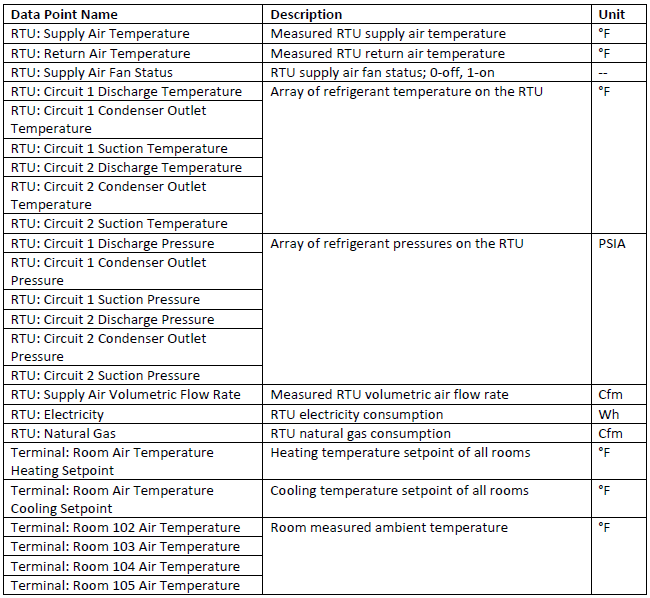
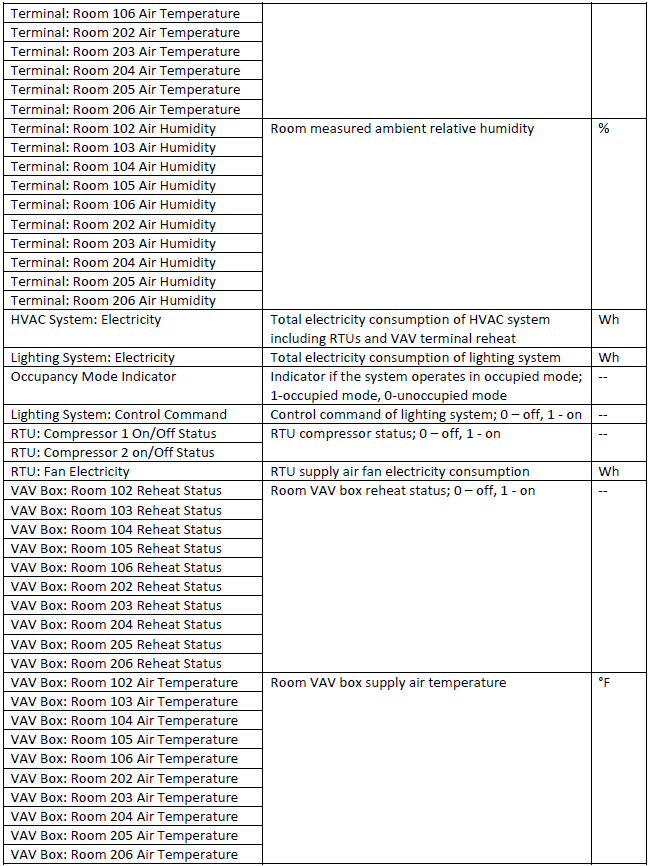
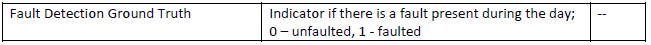

The dataset's faults were intentionally introduced through controlled experiments. Each individual fault was introduced into the unit at midnight and persisted for the whole of a day.

The imposed faults are as follows:

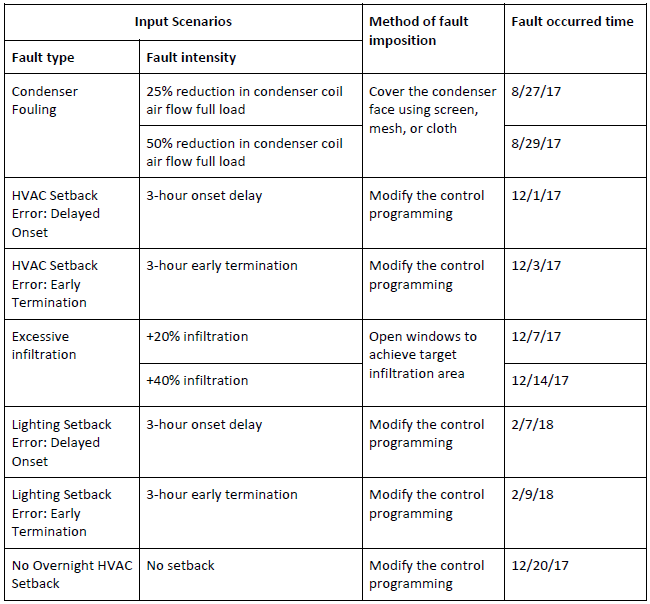
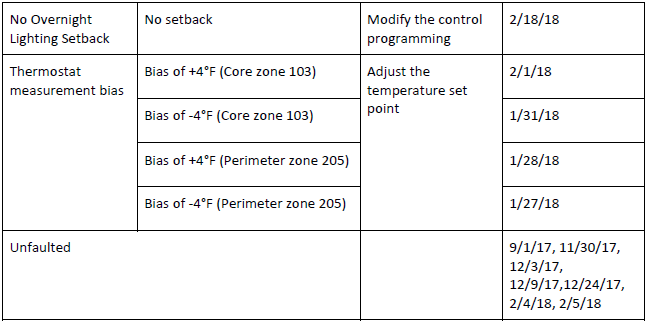

Given the substantial diversity in fault types within this dataset, it's anticipated that different fault detections will have distinct inputs. As a result, feature selection and engineering will be conducted separately for each type of fault.

Detailed information regarding this categorization will be expounded upon in the relevant chapters addressing these specific topics.

Some of the faults refers to similar underlying mechanisms, deviations from intended schedules, but in different systems. These faults will be categorized into two types: faults in HVAC equipment and faults in lighting operation schedules. 

# Import of the relevant libraries and notebook preparation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import warnings
import datetime as dt
import re
from scripts import convert_date, train_evaluate_classification_models, train_evaluate_regression_models

In [2]:
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [3]:
# List of classifiacation algorithms for further use.
classifiers = [['KNeighborsClassifier', KNeighborsClassifier()],
              ['MLPClassifier',MLPClassifier()],
              ['AdaBoostClassifier',AdaBoostClassifier()],
              ['GradientBoostingClassifier',GradientBoostingClassifier()],
              ['CatBoostClassifier', CatBoostClassifier()],
              ['XGBClassifier', XGBClassifier()],
              ['BaggingClassifier', BaggingClassifier()],
              ['RandomForestClassifier', RandomForestClassifier()],
              ['DecisionTreeClassifier', DecisionTreeClassifier()],
              ['LogisticRegression', LogisticRegression()]]

In [4]:
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [5]:
from imblearn.under_sampling import RandomUnderSampler

In [6]:
regressors = [['KNeighborsRegressor', KNeighborsRegressor()],
              ['MLPRegressor',MLPRegressor()],
              ['AdaBoostRegressor',AdaBoostRegressor()],
              ['GradientBoostingRegressor',GradientBoostingRegressor()],
              ['CatBoostRegressor', CatBoostRegressor()],
              ['BaggingRegressor', BaggingRegressor()],
              ['RandomForestRegressor', RandomForestRegressor()],
              ['DecisionTreeRegressor', DecisionTreeRegressor()],
              ['LinearRegression', LinearRegression()]]

In [7]:
warnings.filterwarnings("ignore")

# Initial data cleaning and exploration

In [8]:
data = pd.read_csv('RTU.csv')

In [9]:
data.head()

,Timestamp,RTU: Supply Air Temperature,RTU: Return Air Temperature,RTU: Supply Air Fan Status,RTU: Circuit 1 Discharge Temperature,RTU: Circuit 1 Condenser Outlet Temperature,RTU: Circuit 1 Suction Temperature,RTU: Circuit 2 Discharge Temperature,RTU: Circuit 2 Condenser Outlet Temperature,RTU: Circuit 2 Suction Temperature,...,VAV Box: Room 103 Air Temperature,VAV Box: Room 104 Air Temperature,VAV Box: Room 105 Air Temperature,VAV Box: Room 106 Air Temperature,VAV Box: Room 202 Air Temperature,VAV Box: Room 203 Air Temperature,VAV Box: Room 204 Air Temperature,VAV Box: Room 205 Air Temperature,VAV Box: Room 206 Air Temperature,Fault Detection Ground Truth
0,8/27/2017 0:00,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,8/27/2017 0:01,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,8/27/2017 0:02,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,8/27/2017 0:03,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,8/27/2017 0:04,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 69 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Timestamp                                        30240 non-null  object 
 1   RTU: Supply Air Temperature                      20156 non-null  float64
 2   RTU: Return Air Temperature                      20156 non-null  float64
 3   RTU: Supply Air Fan Status                       30240 non-null  int64  
 4   RTU: Circuit 1 Discharge Temperature             15028 non-null  float64
 5   RTU: Circuit 1 Condenser Outlet Temperature      15028 non-null  float64
 6   RTU: Circuit 1 Suction Temperature               15028 non-null  float64
 7   RTU: Circuit 2 Discharge Temperature             15028 non-null  float64
 8   RTU: Circuit 2 Condenser Outlet Temperature      15028 non-null  float64
 9   RTU: Circuit 2 Suction Tempe

The timestamp column is currently an object datatype. To ensure consistency and proper handling of temporal data, this column will be transformed into the DateTime data type.

It's observed that several columns contain a significant number of null values. This occurrence can be becuse of sensors being deactivated when certain equipment is not operational. Considering the dataset contains a wide array of faults, each requiring distinct subsets of data, null values will be addressed during the process of preparing features specific to each fault. This approach ensures that data gaps are managed appropriately based on the needs of individual fault detection scenarios.

In [11]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [12]:
# Creating list of dates when faults occured accordin to the description.
condenser_fouling = [convert_date('8/27/17'), 
                     convert_date('8/29/17')]
excessive_infiltration = [convert_date('12/7/17'), 
                          convert_date('12/14/17')]
excessive_infiltration_1 = [convert_date('12/7/17')]
excessive_infiltration_2 = [convert_date('12/14/17')]
HVAC_scheadule_fault = [convert_date('12/1/17'),
                        convert_date('12/3/17'),
                        convert_date('12/20/17')]
lighting_scheadule_fault = [convert_date('2/7/18'),
                            convert_date('2/9/18'),
                            convert_date('2/18/18')]
measurement_bias_zone_103 = [convert_date('2/1/18'), 
                             convert_date('1/31/18')]
measurement_bias_zone_205 = [convert_date('1/28/18'), 
                             convert_date('1/27/18')]

In [13]:
# Creating and filling faults column with values according to the dates given earlier.
data['condenser_fouling'] = 0
data['excessive_infiltration'] = 0
data['excessive_infiltration_1'] = 0
data['excessive_infiltration_2'] = 0
data['HVAC_scheadule_fault'] = 0
data['lighting_scheadule_fault'] = 0
data['measurement_bias_zone_103'] = 0
data['measurement_bias_zone_205'] = 0
for date in condenser_fouling:
    data.loc[data['Timestamp'].dt.date == date.date(), 'condenser_fouling'] = 1
for date in excessive_infiltration:
    data.loc[data['Timestamp'].dt.date == date.date(), 'excessive_infiltration'] = 1
for date in excessive_infiltration_1:
    data.loc[data['Timestamp'].dt.date == date.date(), 'excessive_infiltration_1'] = 1
for date in excessive_infiltration_2:
    data.loc[data['Timestamp'].dt.date == date.date(), 'excessive_infiltration_2'] = 1
for date in HVAC_scheadule_fault:
    data.loc[data['Timestamp'].dt.date == date.date(), 'HVAC_scheadule_fault'] = 1
for date in lighting_scheadule_fault:
    data.loc[data['Timestamp'].dt.date == date.date(), 'lighting_scheadule_fault'] = 1
for date in measurement_bias_zone_103:
    data.loc[data['Timestamp'].dt.date == date.date(), 'measurement_bias_zone_103'] = 1
for date in measurement_bias_zone_205:
    data.loc[data['Timestamp'].dt.date == date.date(), 'measurement_bias_zone_205'] = 1

For models connected to the scheadul faults, time value data will be an input. To deliver model this information, relevant columns will be generated. These columns will have data related to the month, day, day of the week, hour, and minute.

In [14]:
data['hour'] = data['Timestamp'].dt.hour
data['minute'] = data['Timestamp'].dt.minute
data['day'] = data['Timestamp'].dt.day
data['month'] = data['Timestamp'].dt.month

# Condenser fouling

## Data exploration and feature engineering

The subsequent phase requires the selection of columns that could potentially correlate with the behavior of condenser fouling. For this specific fault type, we will focus on retaining columns that are not directly associated with the conditions within the office area like temperature area. This approach ensures that the features chosen for analysis are relevant to the specific fault being, enhancing the model's ability to identify patterns and anomalies related to it.

In [24]:
data_cond = data[['RTU: Supply Air Temperature',
       'RTU: Return Air Temperature', 'RTU: Supply Air Fan Status',
       'RTU: Circuit 1 Discharge Temperature',
       'RTU: Circuit 1 Condenser Outlet Temperature',
       'RTU: Circuit 1 Suction Temperature',
       'RTU: Circuit 2 Discharge Temperature',
       'RTU: Circuit 2 Condenser Outlet Temperature',
       'RTU: Circuit 2 Suction Temperature',
       'RTU: Circuit 1 Discharge Pressure',
       'RTU: Circuit 1 Condenser Outlet Pressure',
       'RTU: Circuit 1 Suction Pressure', 'RTU: Circuit 2 Discharge Pressure',
       'RTU: Circuit 2 Condenser Outlet Pressure',
       'RTU: Circuit 2 Suction Pressure',
       'RTU: Supply Air Volumetric Flow Rate', 'RTU: Electricity',
       'Occupancy Mode Indicator','HVAC System: Electricity','RTU: Compressor 1 On/Off Status',
       'RTU: Compressor 2 On/Off Status', 'RTU: Fan Electricity ','condenser_fouling']]

In [25]:
data_cond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 23 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   RTU: Supply Air Temperature                  20156 non-null  float64
 1   RTU: Return Air Temperature                  20156 non-null  float64
 2   RTU: Supply Air Fan Status                   30240 non-null  int64  
 3   RTU: Circuit 1 Discharge Temperature         15028 non-null  float64
 4   RTU: Circuit 1 Condenser Outlet Temperature  15028 non-null  float64
 5   RTU: Circuit 1 Suction Temperature           15028 non-null  float64
 6   RTU: Circuit 2 Discharge Temperature         15028 non-null  float64
 7   RTU: Circuit 2 Condenser Outlet Temperature  15028 non-null  float64
 8   RTU: Circuit 2 Suction Temperature           15028 non-null  float64
 9   RTU: Circuit 1 Discharge Pressure            15028 non-null  float64
 10

Numerous columns within the dataset contain missing values, but "RTU: Circuit 1 Condenser Outlet Pressure" stands out with a higher count of null values. The subsequent phase involves an examination of the values within this column. This analysis will guide the decision-making process regarding the most appropriate course of action to address the missing values within this specific column.

In [26]:
data_cond['RTU: Circuit 1 Condenser Outlet Pressure'].describe()

count    2874.000000
mean     -381.373695
std       375.884149
min      -722.700000
25%      -565.075000
50%      -479.700000
75%      -430.350000
max       814.000000
Name: RTU: Circuit 1 Condenser Outlet Pressure, dtype: float64

In [27]:
data_cond['RTU: Circuit 2 Condenser Outlet Pressure'].describe()

count    15028.000000
mean       182.388194
std         62.981491
min         67.410000
25%        159.000000
50%        166.300000
75%        180.700000
max        617.000000
Name: RTU: Circuit 2 Condenser Outlet Pressure, dtype: float64

The column "RTU: Circuit 1 Condenser Outlet Pressure" have a relatively high standard deviation in its values. This proves that the approach with supplementing the missing data with the average will not fulfill its role. Notably, the presence of both negative and positive values raises suspisions, particularly that the "RTU: Circuit 2 Condenser Outlet Pressure" column exclusively features positive values.

Considering these anomalies, it's plausible that the values in the "RTU: Circuit 1 Condenser Outlet Pressure" column are just wrong. Consequently, a decision has been made to exclude this column from the dataset. Following this exclusion, any rows containing missing data will also be removed. This is considered appropriate as the missing data corresponds to cases where the RTU did not work, making such rows irrelevant to fault prediction algorithms.

In [28]:
data_cond.drop('RTU: Circuit 1 Condenser Outlet Pressure', axis=1, inplace=True)

In [29]:
data_cond.dropna(inplace=True)

In [19]:
plt.figure(figsize=(25,25))
sns.heatmap(data_cond.corr(), annot=True)

NameError: name 'data_cond' is not defined

<Figure size 2500x2500 with 0 Axes>

The dataset is nearly prepared for the training phase. The "RTU: Supply Air Fan Status" column lacks significant correlations with other variables, likely attributed to the removal of rows corresponding to non-operational units. As a result, this column will be eliminated from the dataset.

In [31]:
data_cond.drop('RTU: Supply Air Fan Status', axis=1, inplace=True)

## Feature and target data preparation

In [32]:
X_cond = data_cond.drop('condenser_fouling', axis=1)
y_cond = data_cond['condenser_fouling']

In [33]:
X_train_cond, X_test_cond, y_train_cond, y_test_cond = train_test_split(X_cond, y_cond, test_size=0.1, shuffle=True)

## Classification model training

In [34]:
models_cond, Acc_cond = train_evaluate_classification_models(X_train_cond, X_test_cond, y_train_cond, y_test_cond, classifiers)

Learning rate set to 0.031286
0:	learn: 0.5839233	total: 195ms	remaining: 3m 14s
1:	learn: 0.4912034	total: 208ms	remaining: 1m 43s
2:	learn: 0.4173546	total: 220ms	remaining: 1m 13s
3:	learn: 0.3619119	total: 233ms	remaining: 58s
4:	learn: 0.3085616	total: 250ms	remaining: 49.8s
5:	learn: 0.2646291	total: 260ms	remaining: 43s
6:	learn: 0.2295457	total: 270ms	remaining: 38.3s
7:	learn: 0.1981528	total: 281ms	remaining: 34.8s
8:	learn: 0.1696066	total: 290ms	remaining: 32s
9:	learn: 0.1439799	total: 301ms	remaining: 29.8s
10:	learn: 0.1250804	total: 310ms	remaining: 27.9s
11:	learn: 0.1090559	total: 320ms	remaining: 26.3s
12:	learn: 0.0948676	total: 330ms	remaining: 25.1s
13:	learn: 0.0838671	total: 340ms	remaining: 23.9s
14:	learn: 0.0734343	total: 350ms	remaining: 23s
15:	learn: 0.0657578	total: 360ms	remaining: 22.1s
16:	learn: 0.0579348	total: 369ms	remaining: 21.3s
17:	learn: 0.0514247	total: 378ms	remaining: 20.6s
18:	learn: 0.0463938	total: 388ms	remaining: 20s
19:	learn: 0.04213

173:	learn: 0.0017185	total: 2.08s	remaining: 9.87s
174:	learn: 0.0016855	total: 2.09s	remaining: 9.86s
175:	learn: 0.0016576	total: 2.1s	remaining: 9.84s
176:	learn: 0.0016399	total: 2.11s	remaining: 9.82s
177:	learn: 0.0016378	total: 2.12s	remaining: 9.79s
178:	learn: 0.0016066	total: 2.13s	remaining: 9.77s
179:	learn: 0.0015608	total: 2.14s	remaining: 9.75s
180:	learn: 0.0015583	total: 2.15s	remaining: 9.73s
181:	learn: 0.0015475	total: 2.16s	remaining: 9.71s
182:	learn: 0.0015231	total: 2.17s	remaining: 9.68s
183:	learn: 0.0015051	total: 2.18s	remaining: 9.66s
184:	learn: 0.0015021	total: 2.19s	remaining: 9.64s
185:	learn: 0.0015003	total: 2.2s	remaining: 9.62s
186:	learn: 0.0014726	total: 2.21s	remaining: 9.59s
187:	learn: 0.0014657	total: 2.21s	remaining: 9.57s
188:	learn: 0.0014571	total: 2.22s	remaining: 9.54s
189:	learn: 0.0014404	total: 2.23s	remaining: 9.53s
190:	learn: 0.0014180	total: 2.24s	remaining: 9.5s
191:	learn: 0.0014116	total: 2.25s	remaining: 9.48s
192:	learn: 0.0

332:	learn: 0.0006861	total: 3.54s	remaining: 7.08s
333:	learn: 0.0006752	total: 3.55s	remaining: 7.07s
334:	learn: 0.0006733	total: 3.56s	remaining: 7.06s
335:	learn: 0.0006733	total: 3.56s	remaining: 7.04s
336:	learn: 0.0006673	total: 3.58s	remaining: 7.04s
337:	learn: 0.0006672	total: 3.58s	remaining: 7.02s
338:	learn: 0.0006635	total: 3.6s	remaining: 7.01s
339:	learn: 0.0006615	total: 3.6s	remaining: 7s
340:	learn: 0.0006608	total: 3.61s	remaining: 6.98s
341:	learn: 0.0006608	total: 3.62s	remaining: 6.96s
342:	learn: 0.0006608	total: 3.63s	remaining: 6.95s
343:	learn: 0.0006592	total: 3.64s	remaining: 6.94s
344:	learn: 0.0006530	total: 3.65s	remaining: 6.92s
345:	learn: 0.0006514	total: 3.66s	remaining: 6.91s
346:	learn: 0.0006514	total: 3.66s	remaining: 6.9s
347:	learn: 0.0006481	total: 3.67s	remaining: 6.88s
348:	learn: 0.0006481	total: 3.68s	remaining: 6.87s
349:	learn: 0.0006460	total: 3.69s	remaining: 6.85s
350:	learn: 0.0006389	total: 3.7s	remaining: 6.84s
351:	learn: 0.00063

499:	learn: 0.0005079	total: 5s	remaining: 5s
500:	learn: 0.0005079	total: 5.01s	remaining: 4.99s
501:	learn: 0.0005058	total: 5.02s	remaining: 4.98s
502:	learn: 0.0005058	total: 5.03s	remaining: 4.97s
503:	learn: 0.0005052	total: 5.04s	remaining: 4.96s
504:	learn: 0.0004984	total: 5.05s	remaining: 4.95s
505:	learn: 0.0004970	total: 5.05s	remaining: 4.93s
506:	learn: 0.0004970	total: 5.06s	remaining: 4.92s
507:	learn: 0.0004967	total: 5.07s	remaining: 4.91s
508:	learn: 0.0004967	total: 5.08s	remaining: 4.9s
509:	learn: 0.0004959	total: 5.09s	remaining: 4.89s
510:	learn: 0.0004959	total: 5.1s	remaining: 4.88s
511:	learn: 0.0004959	total: 5.1s	remaining: 4.86s
512:	learn: 0.0004931	total: 5.11s	remaining: 4.85s
513:	learn: 0.0004925	total: 5.12s	remaining: 4.84s
514:	learn: 0.0004925	total: 5.13s	remaining: 4.83s
515:	learn: 0.0004925	total: 5.14s	remaining: 4.82s
516:	learn: 0.0004920	total: 5.15s	remaining: 4.81s
517:	learn: 0.0004920	total: 5.16s	remaining: 4.8s
518:	learn: 0.0004920	

680:	learn: 0.0004542	total: 6.45s	remaining: 3.02s
681:	learn: 0.0004542	total: 6.46s	remaining: 3.01s
682:	learn: 0.0004542	total: 6.46s	remaining: 3s
683:	learn: 0.0004542	total: 6.47s	remaining: 2.99s
684:	learn: 0.0004542	total: 6.48s	remaining: 2.98s
685:	learn: 0.0004542	total: 6.49s	remaining: 2.97s
686:	learn: 0.0004542	total: 6.5s	remaining: 2.96s
687:	learn: 0.0004542	total: 6.51s	remaining: 2.95s
688:	learn: 0.0004542	total: 6.51s	remaining: 2.94s
689:	learn: 0.0004542	total: 6.52s	remaining: 2.93s
690:	learn: 0.0004542	total: 6.53s	remaining: 2.92s
691:	learn: 0.0004542	total: 6.54s	remaining: 2.91s
692:	learn: 0.0004542	total: 6.54s	remaining: 2.9s
693:	learn: 0.0004542	total: 6.55s	remaining: 2.89s
694:	learn: 0.0004542	total: 6.56s	remaining: 2.88s
695:	learn: 0.0004542	total: 6.57s	remaining: 2.87s
696:	learn: 0.0004542	total: 6.58s	remaining: 2.86s
697:	learn: 0.0004542	total: 6.59s	remaining: 2.85s
698:	learn: 0.0004542	total: 6.6s	remaining: 2.84s
699:	learn: 0.0004

840:	learn: 0.0004542	total: 7.7s	remaining: 1.45s
841:	learn: 0.0004542	total: 7.71s	remaining: 1.45s
842:	learn: 0.0004542	total: 7.71s	remaining: 1.44s
843:	learn: 0.0004542	total: 7.72s	remaining: 1.43s
844:	learn: 0.0004542	total: 7.73s	remaining: 1.42s
845:	learn: 0.0004542	total: 7.74s	remaining: 1.41s
846:	learn: 0.0004542	total: 7.74s	remaining: 1.4s
847:	learn: 0.0004542	total: 7.75s	remaining: 1.39s
848:	learn: 0.0004542	total: 7.76s	remaining: 1.38s
849:	learn: 0.0004542	total: 7.77s	remaining: 1.37s
850:	learn: 0.0004542	total: 7.78s	remaining: 1.36s
851:	learn: 0.0004542	total: 7.78s	remaining: 1.35s
852:	learn: 0.0004542	total: 7.79s	remaining: 1.34s
853:	learn: 0.0004542	total: 7.8s	remaining: 1.33s
854:	learn: 0.0004542	total: 7.8s	remaining: 1.32s
855:	learn: 0.0004542	total: 7.81s	remaining: 1.31s
856:	learn: 0.0004542	total: 7.82s	remaining: 1.3s
857:	learn: 0.0004542	total: 7.83s	remaining: 1.29s
858:	learn: 0.0004542	total: 7.83s	remaining: 1.29s
859:	learn: 0.000

## Models evaluation

In [35]:
print(Acc_cond)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.998887       0.997999         0.999365   
1               MLPClassifier        0.972632       0.971981         0.971362   
2          AdaBoostClassifier        1.000000       0.999333         1.000000   
3  GradientBoostingClassifier        1.000000       0.996664         1.000000   
4          CatBoostClassifier        1.000000       0.997999         1.000000   
5               XGBClassifier        1.000000       0.996664         1.000000   
6           BaggingClassifier        0.999926       0.996664         1.000000   
7      RandomForestClassifier        1.000000       0.997332         1.000000   
8      DecisionTreeClassifier        1.000000       0.997999         1.000000   
9          LogisticRegression        0.983461       0.981321         0.911836   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        1.000000      0.991178     0.982

The exceptional evaluation parameters underscore the validity of the assumptions and data employed for training in addressing this task. The favorable outcomes support the utilization of the majority of the models that were employed, indicating their efficacy in fault prediction.

## Conclusions

In this case, the task, apart from clearing the data, was to select the appropriate input data and enter them into the appropriate predictive model. The dependencies between the model inputs and outputs were apparently so obvious that they did not require any additional model adjustments or data balancing. 

This is another proof of the effectiveness of machine learning tools for this type of task. However, it's important to underscore that the attainment of such results hinges on the availability of high-quality data. Consequently, it becomes imperative to execute appropriate experiments or collection procedures to ensure the integrity and reliability of the input data, a prerequisite for the successful application of machine learning methods.

# Excessive infiltration

Faults in this datased was imposed by opening windows in rooms. It wasn't mentioned in description but we will assume that windows were opened in all rooms to the same extent at the same time.

## Data exploration and feature engineering

In contrary to the previous type of fault, all columns with data from office spaces will be taken for training the model, and none of the columns describing work of the RTU.

In [37]:
room_columns = [col for col in data.columns if "Room" in col]

In [38]:
data_ei = data[room_columns]

In [39]:
data_ei['excessive_infiltration'] = data['excessive_infiltration']

In [40]:
data_ei.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 43 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Terminal: Room 102 Air Humidity                  30240 non-null  float64
 1   Terminal: Room 103 Air Humidity                  30240 non-null  float64
 2   Terminal: Room 104 Air Humidity                  30240 non-null  float64
 3   Terminal: Room 105 Air Humidity                  30240 non-null  float64
 4   Terminal: Room 106 Air Humidity                  30240 non-null  float64
 5   Terminal: Room 202 Air Humidity                  30240 non-null  float64
 6   Terminal: Room 203 Air Humidity                  30240 non-null  float64
 7   Terminal: Room 204 Air Humidity                  30240 non-null  float64
 8   Terminal: Room 205 Air Humidity                  30240 non-null  float64
 9   Terminal: Room 206 Air Humid

In [41]:
data[data['VAV Box: Room 205 Air Temperature'].isnull()]

,Timestamp,RTU: Supply Air Temperature,RTU: Return Air Temperature,RTU: Supply Air Fan Status,RTU: Circuit 1 Discharge Temperature,RTU: Circuit 1 Condenser Outlet Temperature,RTU: Circuit 1 Suction Temperature,RTU: Circuit 2 Discharge Temperature,RTU: Circuit 2 Condenser Outlet Temperature,RTU: Circuit 2 Suction Temperature,...,condenser_fouling,excessive_infiltration,excessive_infiltration_1,excessive_infiltration_2,HVAC_scheadule_fault,lighting_scheadule_fault,measurement_bias_zone_103,measurement_bias_zone_205,hour,minute
0,2017-08-27 00:00:00,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1,2017-08-27 00:01:00,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,1
2,2017-08-27 00:02:00,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,2
3,2017-08-27 00:03:00,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,3
4,2017-08-27 00:04:00,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30235,2018-02-18 23:55:00,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,23,55
30236,2018-02-18 23:56:00,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,23,56
30237,2018-02-18 23:57:00,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,23,57
30238,2018-02-18 23:58:00,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,23,58


There are 1/3 of null data for VAV Box Room Air Temperature readings. All this missing data occurs at the same time and it seems that this is the time when RTU is not working. In the next step we will try to train 2 types of models: one without rows with null values and one without columns with null values.

Excessive infiltration occurs also when the RTU is not working so it should be useful to detect this type of fault during night hours as well.

In [42]:
data_ei_1 = data_ei.copy()

In [43]:
not_vav_col = [col for col in data_ei.columns if "VAV" not in col]

In [44]:
data_ei.dropna(inplace=True)

In [45]:
data_ei_1 = data_ei_1[not_vav_col]

<AxesSubplot:>

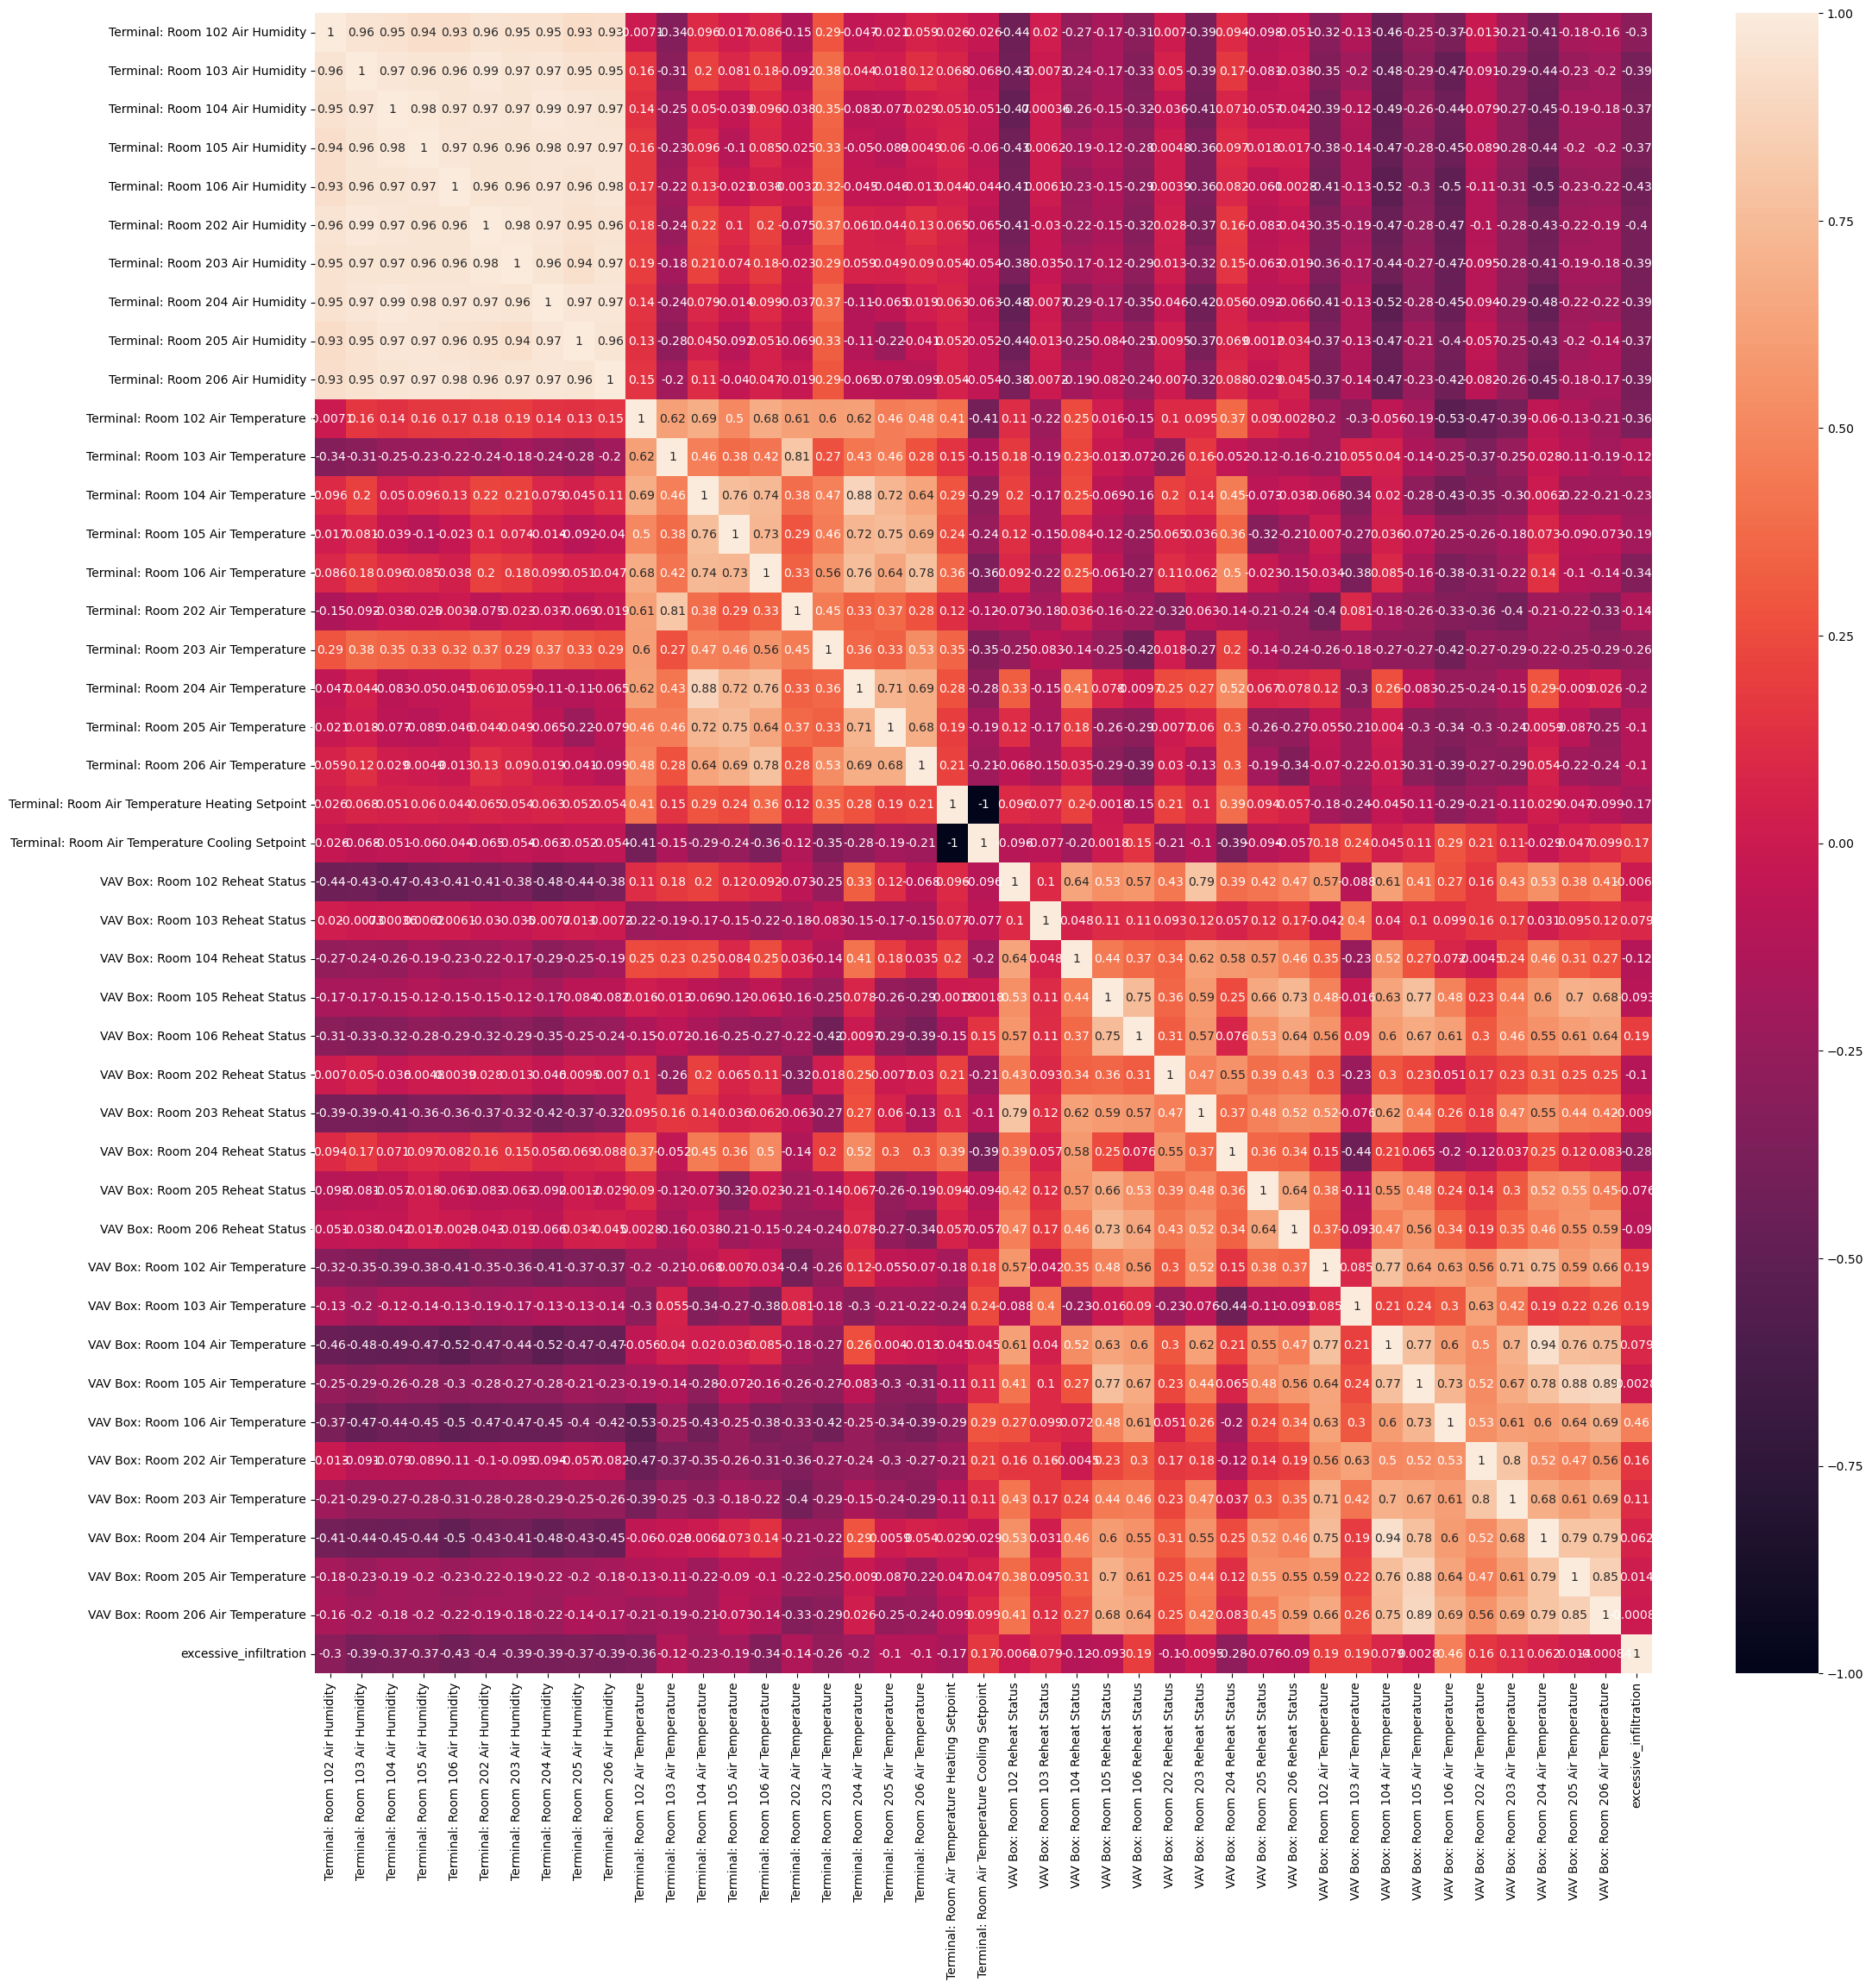

In [46]:
plt.figure(figsize=(25,25))
sns.heatmap(data_ei.corr(), annot=True)

<AxesSubplot:>

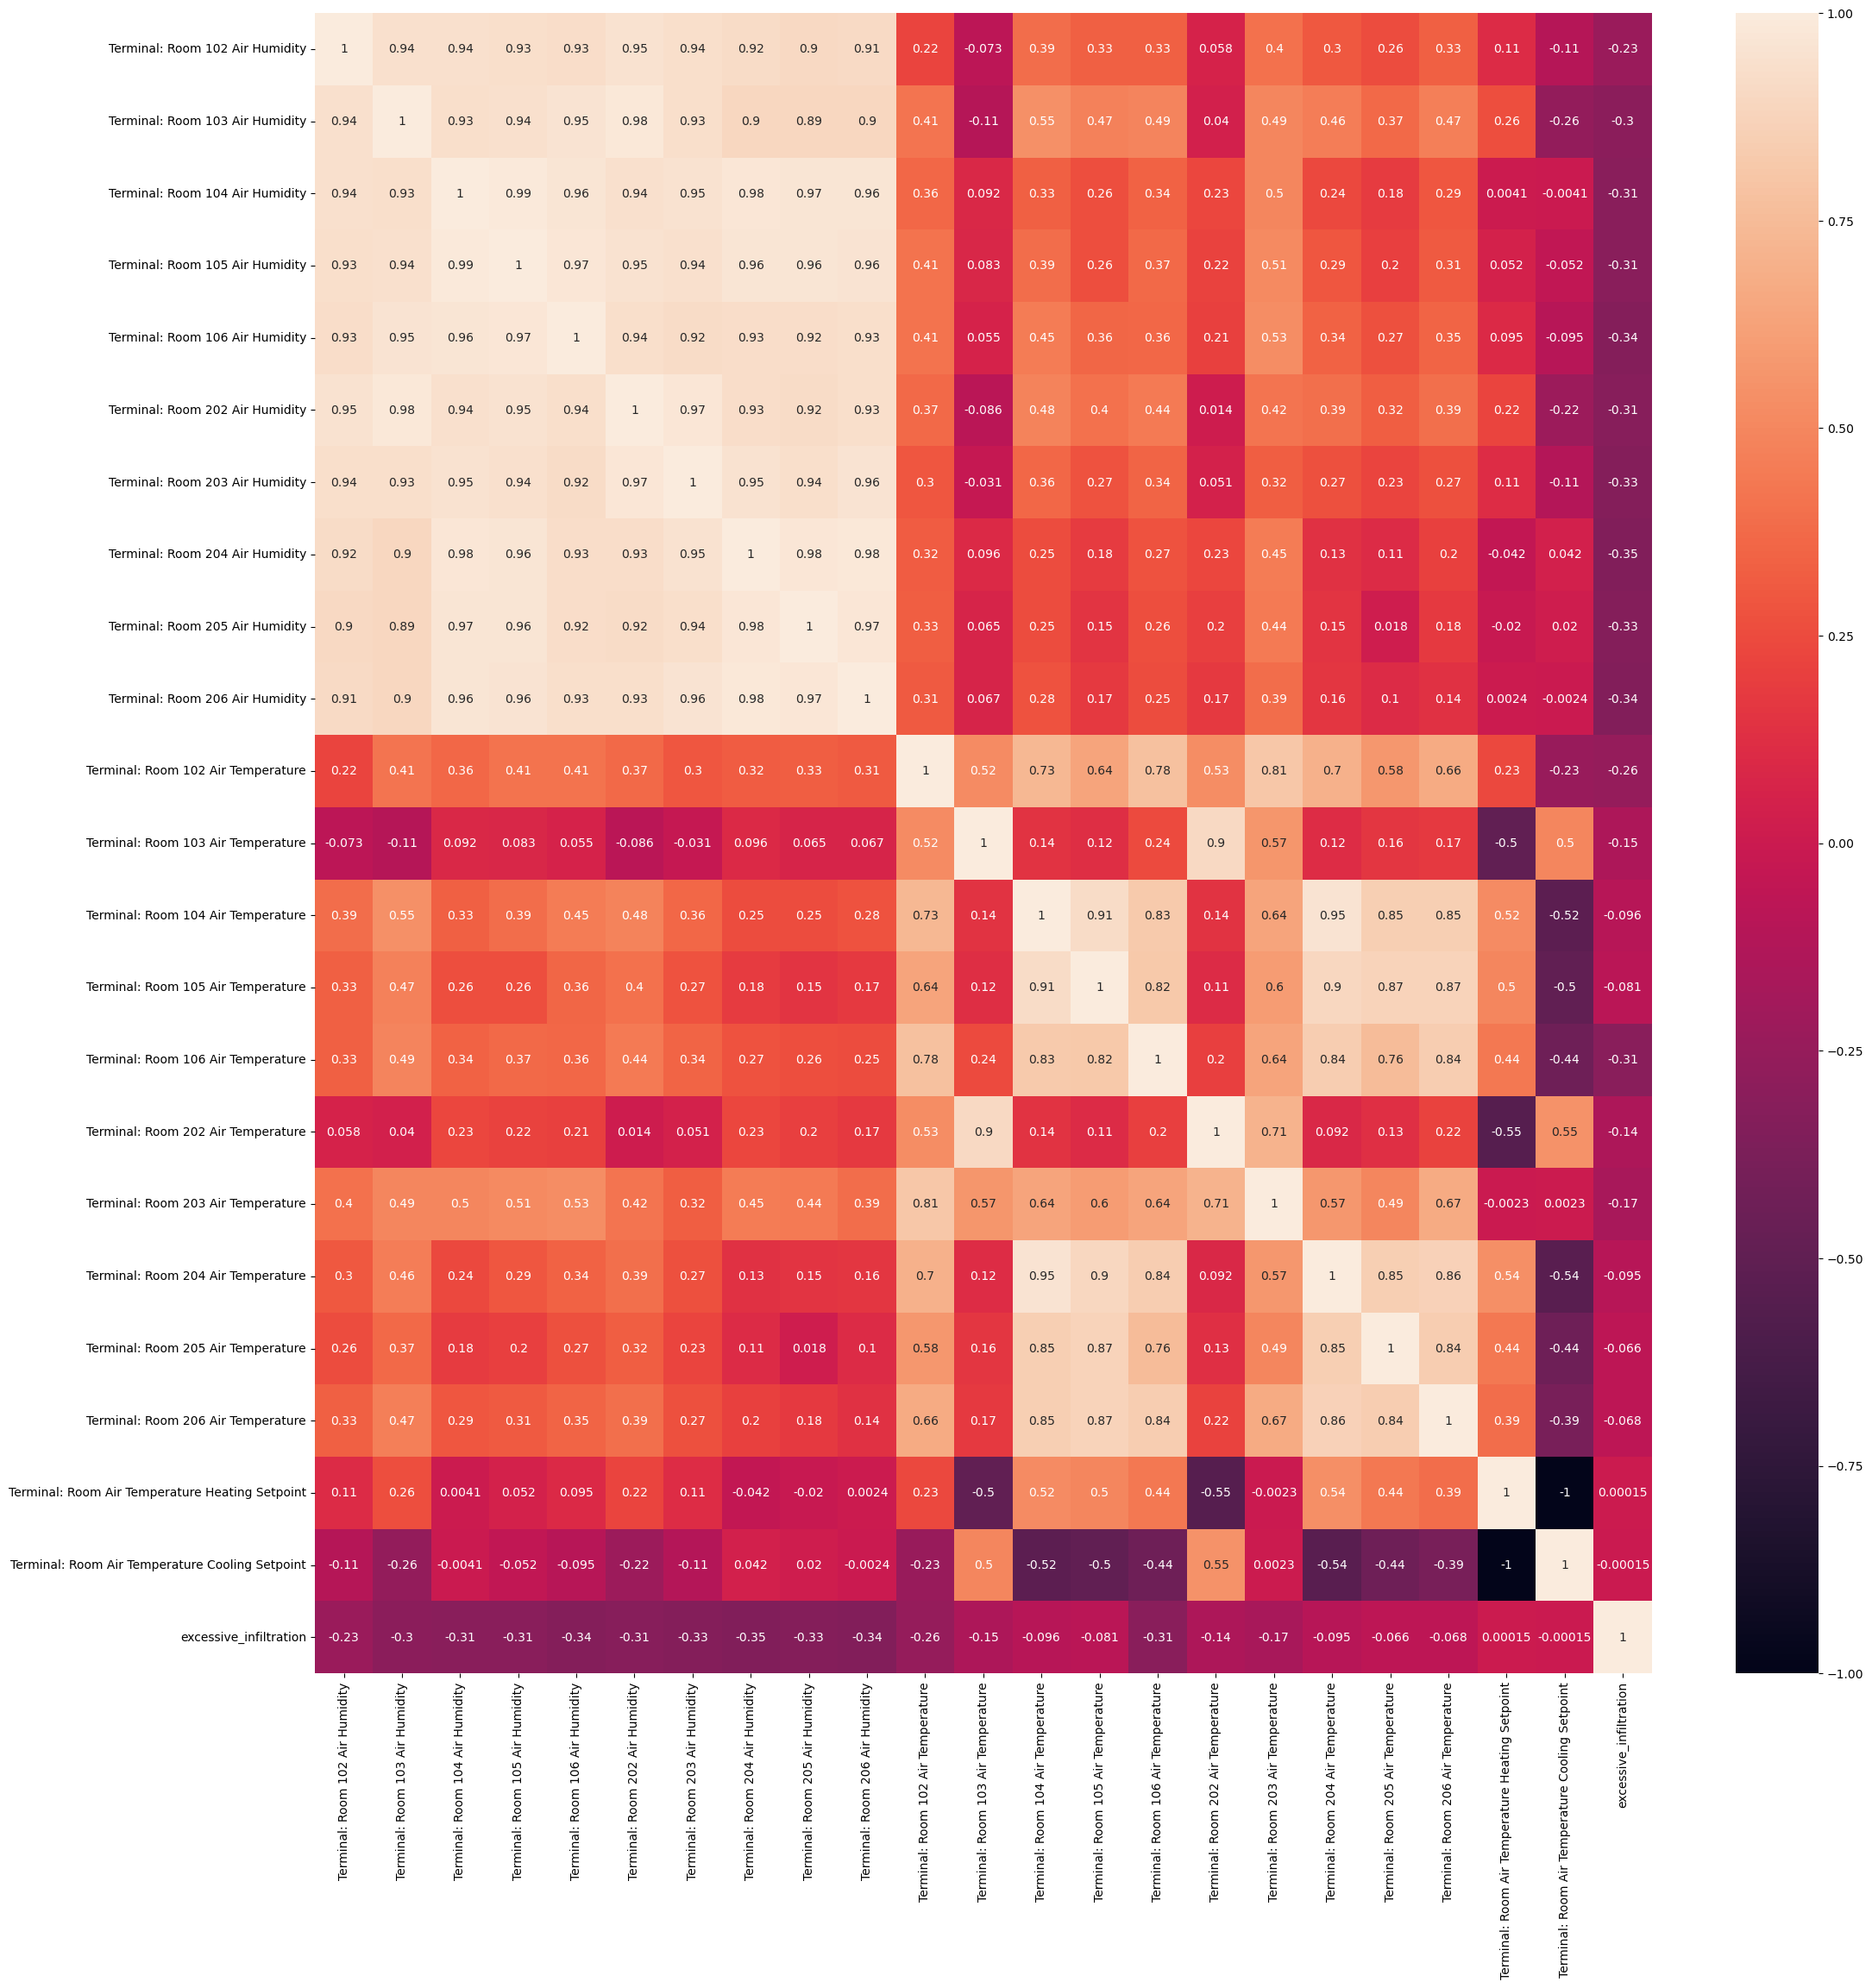

In [47]:
plt.figure(figsize=(25,25))
sns.heatmap(data_ei_1.corr(), annot=True)

## Feature and target data preparation

In [48]:
X_ei = data_ei.drop('excessive_infiltration', axis=1)
y_ei = data_ei['excessive_infiltration']
X_ei_1 = data_ei_1.drop('excessive_infiltration', axis=1)
y_ei_1 = data_ei_1['excessive_infiltration']

In [49]:
X_train_ei, X_test_ei, y_train_ei, y_test_ei = train_test_split(X_ei, y_ei, test_size=0.1, shuffle=True)
X_train_ei_1, X_test_ei_1, y_train_ei_1, y_test_ei_1 = train_test_split(X_ei_1, y_ei_1, test_size=0.1, shuffle=True)

## Classification models training

In [50]:
models_ei, Acc_ei = train_evaluate_classification_models(X_train_ei, X_test_ei, y_train_ei, y_test_ei, classifiers)

Learning rate set to 0.035512
0:	learn: 0.6218503	total: 14.9ms	remaining: 14.9s
1:	learn: 0.5691261	total: 27.2ms	remaining: 13.6s
2:	learn: 0.5216709	total: 40.6ms	remaining: 13.5s
3:	learn: 0.4662530	total: 54.1ms	remaining: 13.5s
4:	learn: 0.4072617	total: 66.9ms	remaining: 13.3s
5:	learn: 0.3633964	total: 79.9ms	remaining: 13.2s
6:	learn: 0.3334962	total: 92.7ms	remaining: 13.2s
7:	learn: 0.3116237	total: 106ms	remaining: 13.2s
8:	learn: 0.2935424	total: 120ms	remaining: 13.2s
9:	learn: 0.2707857	total: 132ms	remaining: 13.1s
10:	learn: 0.2575508	total: 145ms	remaining: 13s
11:	learn: 0.2452320	total: 158ms	remaining: 13s
12:	learn: 0.2314788	total: 171ms	remaining: 13s
13:	learn: 0.2217865	total: 184ms	remaining: 13s
14:	learn: 0.2107240	total: 199ms	remaining: 13.1s
15:	learn: 0.2036255	total: 220ms	remaining: 13.6s
16:	learn: 0.1940546	total: 236ms	remaining: 13.7s
17:	learn: 0.1841717	total: 250ms	remaining: 13.6s
18:	learn: 0.1730155	total: 263ms	remaining: 13.6s
19:	learn: 0

173:	learn: 0.0073142	total: 2.54s	remaining: 12.1s
174:	learn: 0.0072535	total: 2.56s	remaining: 12.1s
175:	learn: 0.0071415	total: 2.57s	remaining: 12s
176:	learn: 0.0070699	total: 2.59s	remaining: 12s
177:	learn: 0.0069866	total: 2.61s	remaining: 12s
178:	learn: 0.0069293	total: 2.62s	remaining: 12s
179:	learn: 0.0068248	total: 2.63s	remaining: 12s
180:	learn: 0.0067577	total: 2.65s	remaining: 12s
181:	learn: 0.0066538	total: 2.66s	remaining: 12s
182:	learn: 0.0066126	total: 2.67s	remaining: 11.9s
183:	learn: 0.0065710	total: 2.69s	remaining: 11.9s
184:	learn: 0.0065143	total: 2.7s	remaining: 11.9s
185:	learn: 0.0064837	total: 2.72s	remaining: 11.9s
186:	learn: 0.0064197	total: 2.73s	remaining: 11.9s
187:	learn: 0.0063531	total: 2.75s	remaining: 11.9s
188:	learn: 0.0062849	total: 2.77s	remaining: 11.9s
189:	learn: 0.0062219	total: 2.79s	remaining: 11.9s
190:	learn: 0.0061398	total: 2.8s	remaining: 11.9s
191:	learn: 0.0060909	total: 2.81s	remaining: 11.8s
192:	learn: 0.0060337	total:

342:	learn: 0.0017783	total: 5.38s	remaining: 10.3s
343:	learn: 0.0017620	total: 5.39s	remaining: 10.3s
344:	learn: 0.0017512	total: 5.41s	remaining: 10.3s
345:	learn: 0.0017447	total: 5.42s	remaining: 10.2s
346:	learn: 0.0017300	total: 5.44s	remaining: 10.2s
347:	learn: 0.0017255	total: 5.45s	remaining: 10.2s
348:	learn: 0.0017165	total: 5.46s	remaining: 10.2s
349:	learn: 0.0017093	total: 5.47s	remaining: 10.2s
350:	learn: 0.0016957	total: 5.49s	remaining: 10.1s
351:	learn: 0.0016841	total: 5.5s	remaining: 10.1s
352:	learn: 0.0016693	total: 5.52s	remaining: 10.1s
353:	learn: 0.0016633	total: 5.53s	remaining: 10.1s
354:	learn: 0.0016546	total: 5.54s	remaining: 10.1s
355:	learn: 0.0016393	total: 5.56s	remaining: 10.1s
356:	learn: 0.0016297	total: 5.57s	remaining: 10s
357:	learn: 0.0016248	total: 5.59s	remaining: 10s
358:	learn: 0.0016148	total: 5.61s	remaining: 10s
359:	learn: 0.0016060	total: 5.62s	remaining: 9.99s
360:	learn: 0.0015998	total: 5.63s	remaining: 9.97s
361:	learn: 0.00158

516:	learn: 0.0009015	total: 7.74s	remaining: 7.23s
517:	learn: 0.0009013	total: 7.75s	remaining: 7.21s
518:	learn: 0.0008994	total: 7.76s	remaining: 7.19s
519:	learn: 0.0008994	total: 7.77s	remaining: 7.17s
520:	learn: 0.0008994	total: 7.78s	remaining: 7.16s
521:	learn: 0.0008994	total: 7.79s	remaining: 7.14s
522:	learn: 0.0008994	total: 7.81s	remaining: 7.12s
523:	learn: 0.0008994	total: 7.82s	remaining: 7.1s
524:	learn: 0.0008994	total: 7.83s	remaining: 7.08s
525:	learn: 0.0008994	total: 7.84s	remaining: 7.07s
526:	learn: 0.0008994	total: 7.85s	remaining: 7.05s
527:	learn: 0.0008994	total: 7.86s	remaining: 7.03s
528:	learn: 0.0008994	total: 7.87s	remaining: 7.01s
529:	learn: 0.0008994	total: 7.88s	remaining: 6.99s
530:	learn: 0.0008994	total: 7.89s	remaining: 6.97s
531:	learn: 0.0008994	total: 7.91s	remaining: 6.96s
532:	learn: 0.0008994	total: 7.92s	remaining: 6.94s
533:	learn: 0.0008994	total: 7.93s	remaining: 6.92s
534:	learn: 0.0008994	total: 7.94s	remaining: 6.9s
535:	learn: 0.

681:	learn: 0.0008994	total: 9.63s	remaining: 4.49s
682:	learn: 0.0008994	total: 9.64s	remaining: 4.47s
683:	learn: 0.0008994	total: 9.65s	remaining: 4.46s
684:	learn: 0.0008994	total: 9.67s	remaining: 4.45s
685:	learn: 0.0008994	total: 9.68s	remaining: 4.43s
686:	learn: 0.0008994	total: 9.69s	remaining: 4.41s
687:	learn: 0.0008994	total: 9.7s	remaining: 4.4s
688:	learn: 0.0008994	total: 9.71s	remaining: 4.38s
689:	learn: 0.0008994	total: 9.73s	remaining: 4.37s
690:	learn: 0.0008994	total: 9.74s	remaining: 4.36s
691:	learn: 0.0008994	total: 9.75s	remaining: 4.34s
692:	learn: 0.0008994	total: 9.76s	remaining: 4.33s
693:	learn: 0.0008994	total: 9.78s	remaining: 4.31s
694:	learn: 0.0008994	total: 9.79s	remaining: 4.3s
695:	learn: 0.0008994	total: 9.81s	remaining: 4.28s
696:	learn: 0.0008994	total: 9.82s	remaining: 4.27s
697:	learn: 0.0008994	total: 9.84s	remaining: 4.26s
698:	learn: 0.0008994	total: 9.86s	remaining: 4.24s
699:	learn: 0.0008994	total: 9.87s	remaining: 4.23s
700:	learn: 0.0

857:	learn: 0.0008893	total: 11.9s	remaining: 1.98s
858:	learn: 0.0008893	total: 12s	remaining: 1.96s
859:	learn: 0.0008893	total: 12s	remaining: 1.95s
860:	learn: 0.0008885	total: 12s	remaining: 1.93s
861:	learn: 0.0008885	total: 12s	remaining: 1.92s
862:	learn: 0.0008885	total: 12s	remaining: 1.91s
863:	learn: 0.0008885	total: 12s	remaining: 1.89s
864:	learn: 0.0008885	total: 12s	remaining: 1.88s
865:	learn: 0.0008885	total: 12s	remaining: 1.86s
866:	learn: 0.0008885	total: 12.1s	remaining: 1.85s
867:	learn: 0.0008885	total: 12.1s	remaining: 1.83s
868:	learn: 0.0008885	total: 12.1s	remaining: 1.82s
869:	learn: 0.0008884	total: 12.1s	remaining: 1.8s
870:	learn: 0.0008884	total: 12.1s	remaining: 1.79s
871:	learn: 0.0008884	total: 12.1s	remaining: 1.78s
872:	learn: 0.0008884	total: 12.1s	remaining: 1.76s
873:	learn: 0.0008884	total: 12.1s	remaining: 1.75s
874:	learn: 0.0008884	total: 12.1s	remaining: 1.73s
875:	learn: 0.0008884	total: 12.2s	remaining: 1.72s
876:	learn: 0.0008884	total: 

In [51]:
models_ei_1, Acc_ei_1 = train_evaluate_classification_models(X_train_ei_1, X_test_ei_1, y_train_ei_1, y_test_ei_1, classifiers)

Learning rate set to 0.042228
0:	learn: 0.5948128	total: 14ms	remaining: 13.9s
1:	learn: 0.5204141	total: 26.4ms	remaining: 13.2s
2:	learn: 0.4571584	total: 38.9ms	remaining: 12.9s
3:	learn: 0.4126599	total: 51.5ms	remaining: 12.8s
4:	learn: 0.3655552	total: 64.8ms	remaining: 12.9s
5:	learn: 0.3346303	total: 76.7ms	remaining: 12.7s
6:	learn: 0.3065115	total: 89ms	remaining: 12.6s
7:	learn: 0.2859238	total: 101ms	remaining: 12.5s
8:	learn: 0.2654014	total: 114ms	remaining: 12.5s
9:	learn: 0.2385638	total: 126ms	remaining: 12.5s
10:	learn: 0.2266221	total: 138ms	remaining: 12.4s
11:	learn: 0.2093744	total: 150ms	remaining: 12.3s
12:	learn: 0.1984263	total: 162ms	remaining: 12.3s
13:	learn: 0.1874969	total: 175ms	remaining: 12.3s
14:	learn: 0.1808964	total: 186ms	remaining: 12.2s
15:	learn: 0.1677815	total: 199ms	remaining: 12.2s
16:	learn: 0.1574069	total: 216ms	remaining: 12.5s
17:	learn: 0.1522886	total: 234ms	remaining: 12.8s
18:	learn: 0.1469963	total: 248ms	remaining: 12.8s
19:	lear

160:	learn: 0.0083003	total: 2.56s	remaining: 13.3s
161:	learn: 0.0082420	total: 2.58s	remaining: 13.3s
162:	learn: 0.0081453	total: 2.59s	remaining: 13.3s
163:	learn: 0.0080183	total: 2.6s	remaining: 13.3s
164:	learn: 0.0079309	total: 2.62s	remaining: 13.2s
165:	learn: 0.0078345	total: 2.63s	remaining: 13.2s
166:	learn: 0.0077739	total: 2.64s	remaining: 13.2s
167:	learn: 0.0076681	total: 2.65s	remaining: 13.1s
168:	learn: 0.0075709	total: 2.67s	remaining: 13.1s
169:	learn: 0.0075013	total: 2.68s	remaining: 13.1s
170:	learn: 0.0074282	total: 2.7s	remaining: 13.1s
171:	learn: 0.0073800	total: 2.71s	remaining: 13.1s
172:	learn: 0.0073207	total: 2.73s	remaining: 13s
173:	learn: 0.0072133	total: 2.74s	remaining: 13s
174:	learn: 0.0071474	total: 2.75s	remaining: 13s
175:	learn: 0.0070539	total: 2.77s	remaining: 13s
176:	learn: 0.0070134	total: 2.79s	remaining: 13s
177:	learn: 0.0069278	total: 2.81s	remaining: 13s
178:	learn: 0.0068761	total: 2.82s	remaining: 12.9s
179:	learn: 0.0067936	tota

323:	learn: 0.0022865	total: 4.72s	remaining: 9.86s
324:	learn: 0.0022817	total: 4.74s	remaining: 9.85s
325:	learn: 0.0022699	total: 4.76s	remaining: 9.84s
326:	learn: 0.0022585	total: 4.77s	remaining: 9.82s
327:	learn: 0.0022449	total: 4.79s	remaining: 9.8s
328:	learn: 0.0022334	total: 4.8s	remaining: 9.79s
329:	learn: 0.0022229	total: 4.81s	remaining: 9.77s
330:	learn: 0.0022118	total: 4.82s	remaining: 9.75s
331:	learn: 0.0021912	total: 4.84s	remaining: 9.74s
332:	learn: 0.0021850	total: 4.85s	remaining: 9.72s
333:	learn: 0.0021581	total: 4.86s	remaining: 9.7s
334:	learn: 0.0021526	total: 4.88s	remaining: 9.68s
335:	learn: 0.0021374	total: 4.89s	remaining: 9.66s
336:	learn: 0.0021240	total: 4.9s	remaining: 9.64s
337:	learn: 0.0021160	total: 4.91s	remaining: 9.62s
338:	learn: 0.0021074	total: 4.93s	remaining: 9.61s
339:	learn: 0.0021005	total: 4.94s	remaining: 9.59s
340:	learn: 0.0020916	total: 4.96s	remaining: 9.58s
341:	learn: 0.0020689	total: 4.97s	remaining: 9.56s
342:	learn: 0.00

485:	learn: 0.0010379	total: 6.86s	remaining: 7.25s
486:	learn: 0.0010363	total: 6.87s	remaining: 7.24s
487:	learn: 0.0010296	total: 6.88s	remaining: 7.22s
488:	learn: 0.0010264	total: 6.9s	remaining: 7.21s
489:	learn: 0.0010231	total: 6.91s	remaining: 7.19s
490:	learn: 0.0010209	total: 6.92s	remaining: 7.18s
491:	learn: 0.0010076	total: 6.93s	remaining: 7.16s
492:	learn: 0.0010055	total: 6.95s	remaining: 7.14s
493:	learn: 0.0010015	total: 6.96s	remaining: 7.13s
494:	learn: 0.0009992	total: 6.97s	remaining: 7.11s
495:	learn: 0.0009931	total: 6.98s	remaining: 7.1s
496:	learn: 0.0009911	total: 7s	remaining: 7.08s
497:	learn: 0.0009839	total: 7.01s	remaining: 7.06s
498:	learn: 0.0009805	total: 7.02s	remaining: 7.05s
499:	learn: 0.0009753	total: 7.03s	remaining: 7.03s
500:	learn: 0.0009730	total: 7.04s	remaining: 7.02s
501:	learn: 0.0009707	total: 7.06s	remaining: 7s
502:	learn: 0.0009693	total: 7.07s	remaining: 6.99s
503:	learn: 0.0009679	total: 7.09s	remaining: 6.97s
504:	learn: 0.000962

659:	learn: 0.0007152	total: 8.99s	remaining: 4.63s
660:	learn: 0.0007152	total: 9s	remaining: 4.62s
661:	learn: 0.0007152	total: 9.01s	remaining: 4.6s
662:	learn: 0.0007152	total: 9.02s	remaining: 4.59s
663:	learn: 0.0007152	total: 9.04s	remaining: 4.57s
664:	learn: 0.0007152	total: 9.05s	remaining: 4.56s
665:	learn: 0.0007152	total: 9.06s	remaining: 4.54s
666:	learn: 0.0007152	total: 9.07s	remaining: 4.53s
667:	learn: 0.0007152	total: 9.08s	remaining: 4.51s
668:	learn: 0.0007152	total: 9.09s	remaining: 4.5s
669:	learn: 0.0007152	total: 9.1s	remaining: 4.48s
670:	learn: 0.0007152	total: 9.11s	remaining: 4.47s
671:	learn: 0.0007151	total: 9.12s	remaining: 4.45s
672:	learn: 0.0007151	total: 9.13s	remaining: 4.43s
673:	learn: 0.0007151	total: 9.14s	remaining: 4.42s
674:	learn: 0.0007151	total: 9.15s	remaining: 4.41s
675:	learn: 0.0007151	total: 9.17s	remaining: 4.39s
676:	learn: 0.0007151	total: 9.19s	remaining: 4.38s
677:	learn: 0.0007151	total: 9.2s	remaining: 4.37s
678:	learn: 0.00071

824:	learn: 0.0007128	total: 10.8s	remaining: 2.3s
825:	learn: 0.0007128	total: 10.9s	remaining: 2.29s
826:	learn: 0.0007128	total: 10.9s	remaining: 2.27s
827:	learn: 0.0007128	total: 10.9s	remaining: 2.26s
828:	learn: 0.0007128	total: 10.9s	remaining: 2.25s
829:	learn: 0.0007128	total: 10.9s	remaining: 2.23s
830:	learn: 0.0007128	total: 10.9s	remaining: 2.22s
831:	learn: 0.0007128	total: 10.9s	remaining: 2.21s
832:	learn: 0.0007128	total: 10.9s	remaining: 2.19s
833:	learn: 0.0007128	total: 10.9s	remaining: 2.18s
834:	learn: 0.0007128	total: 11s	remaining: 2.17s
835:	learn: 0.0007128	total: 11s	remaining: 2.15s
836:	learn: 0.0007128	total: 11s	remaining: 2.14s
837:	learn: 0.0007128	total: 11s	remaining: 2.12s
838:	learn: 0.0007128	total: 11s	remaining: 2.11s
839:	learn: 0.0007128	total: 11s	remaining: 2.1s
840:	learn: 0.0007128	total: 11s	remaining: 2.08s
841:	learn: 0.0007128	total: 11s	remaining: 2.07s
842:	learn: 0.0007128	total: 11s	remaining: 2.06s
843:	learn: 0.0007128	total: 11.

994:	learn: 0.0006702	total: 12.8s	remaining: 64.1ms
995:	learn: 0.0006702	total: 12.8s	remaining: 51.3ms
996:	learn: 0.0006702	total: 12.8s	remaining: 38.5ms
997:	learn: 0.0006702	total: 12.8s	remaining: 25.6ms
998:	learn: 0.0006702	total: 12.8s	remaining: 12.8ms
999:	learn: 0.0006702	total: 12.8s	remaining: 0us


## Models evaluation

In [52]:
print(Acc_ei)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.999724       0.999008         1.000000   
1               MLPClassifier        0.986770       0.983631         0.967098   
2          AdaBoostClassifier        0.995976       0.994544         0.988175   
3  GradientBoostingClassifier        0.998456       0.996528         0.999486   
4          CatBoostClassifier        1.000000       1.000000         1.000000   
5               XGBClassifier        1.000000       0.999504         1.000000   
6           BaggingClassifier        0.999724       0.996528         0.999492   
7      RandomForestClassifier        1.000000       1.000000         1.000000   
8      DecisionTreeClassifier        1.000000       0.996032         1.000000   
9          LogisticRegression        0.986439       0.985119         0.949011   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        1.000000      0.997465     0.991

In [53]:
print(Acc_ei_1)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.999963       1.000000         0.999613   
1               MLPClassifier        0.992504       0.993056         0.980583   
2          AdaBoostClassifier        0.990998       0.990741         0.967561   
3  GradientBoostingClassifier        0.996803       0.996032         0.999199   
4          CatBoostClassifier        1.000000       1.000000         1.000000   
5               XGBClassifier        1.000000       1.000000         1.000000   
6           BaggingClassifier        1.000000       0.998347         1.000000   
7      RandomForestClassifier        1.000000       1.000000         1.000000   
8      DecisionTreeClassifier        1.000000       0.997024         1.000000   
9          LogisticRegression        0.986368       0.987765         0.953966   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        1.000000      1.000000     1.000

Both type of models performed excelently, and deleting columns with VAV data doesn't impacted on models performance. Therefore this type of models will be preferred because they can work even when the RTU is not. As for particular model for this task we could choose CatBoostClassifier or XGBClassifier, as both of this model were 100% correct.

<BarContainer object of 22 artists>

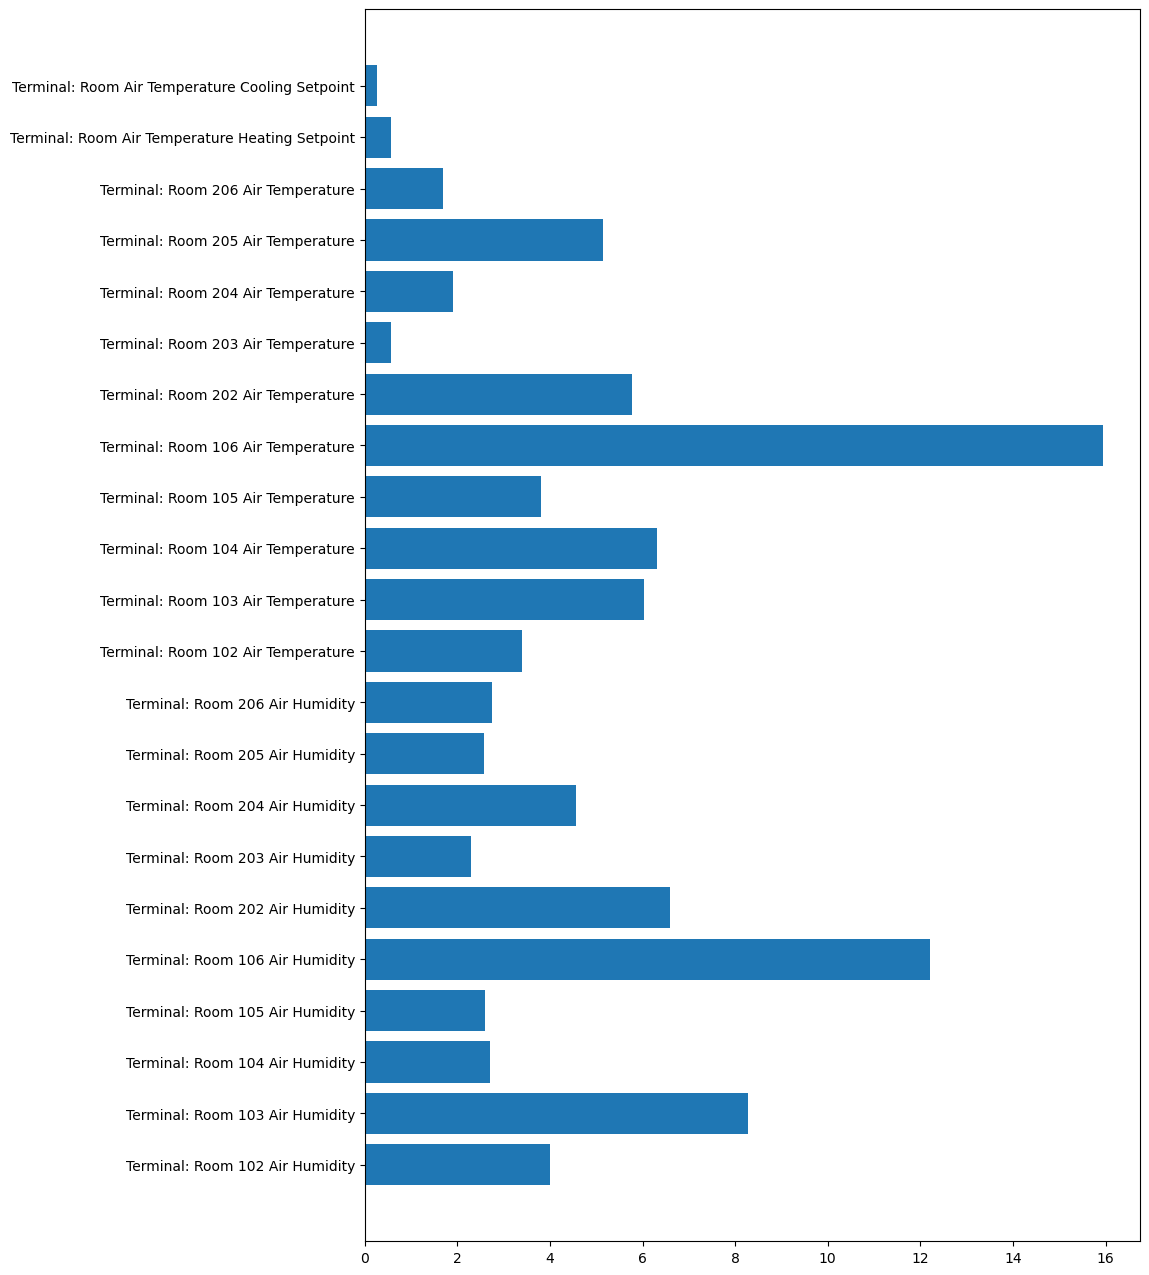

In [54]:
plt.figure(figsize=(10,16))
plt.barh(X_ei_1.columns, models_ei_1[4].get_feature_importance())

Looking at the feature importancej, we notice that there are noticeable differences between them. However, it is difficult to logically explain the differences between these weights. There seems to be no reason why for example Room 106 is more important than Room 105. 

There could be 2 possibilities for this: 
1. Room shape, size and localisation of the room affect how conditions in a room will change in the face of infiltration.
2. Specific weather conditions during the tests affected weights in the model.

If the posiibility 1 is true then this model is correct, hovewer the building is a very simple block with regularly spaced windows.

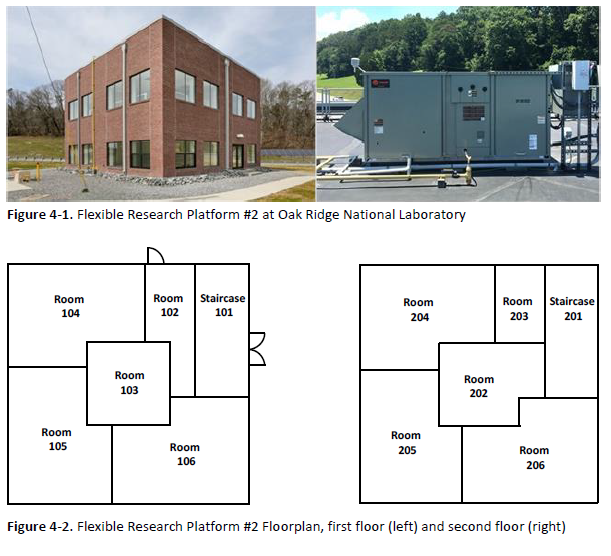

On the other hand if possibility 2 is true then model isn't correct even those terrific model evaluation parameters. We could say that the model was in overtrained  that the model was overtrained in such a way that it was adapted to the specific weather that took place during that period. Perhaps that model will not be adapted to detect this type of faults under other atmospheric conditions.

The fault simulation took place on 2 days separated by 7 days. The weather these days was probably a bit different. To check if the hypothesis 2 is true or not we could train model without data from one of these day, and then we could try to predict the outcome this day.

## Additional Model check - models trained witht only one faulted day

### Data preparation for test model training

In [55]:
data_ei_2 = data_ei_1.copy()
data_ei_2['excessive_infiltration_1'] = data['excessive_infiltration_1']

In [56]:
# Selecting data without one day with fault.
data_ei_2 = data_ei_2[data_ei_2['excessive_infiltration_1']==0]

In [57]:
X_ei_2 = data_ei_2[X_ei_1.columns]
y_ei_2 = data_ei_2['excessive_infiltration']

In [58]:
X_train_ei_2, X_test_ei_2, y_train_ei_2, y_test_ei_2 = train_test_split(X_ei_2, y_ei_2, test_size=0.1, shuffle=True)

### Test model training

In [59]:
classifier = [['CatBoostClassifier', CatBoostClassifier()]]

In [60]:
models_ei_2, acc_ei_2 = train_evaluate_classification_models(X_train_ei_2, X_test_ei_2, y_train_ei_2, y_test_ei_2, classifier)

Learning rate set to 0.041358
0:	learn: 0.5800739	total: 17.3ms	remaining: 17.3s
1:	learn: 0.4826574	total: 32.3ms	remaining: 16.1s
2:	learn: 0.4097213	total: 47.2ms	remaining: 15.7s
3:	learn: 0.3269285	total: 64.1ms	remaining: 16s
4:	learn: 0.2785151	total: 82.4ms	remaining: 16.4s
5:	learn: 0.2376155	total: 98.1ms	remaining: 16.2s
6:	learn: 0.1941516	total: 114ms	remaining: 16.2s
7:	learn: 0.1660570	total: 137ms	remaining: 17s
8:	learn: 0.1423239	total: 153ms	remaining: 16.9s
9:	learn: 0.1288694	total: 171ms	remaining: 16.9s
10:	learn: 0.1112328	total: 189ms	remaining: 17s
11:	learn: 0.0984717	total: 210ms	remaining: 17.3s
12:	learn: 0.0861697	total: 235ms	remaining: 17.9s
13:	learn: 0.0741700	total: 253ms	remaining: 17.8s
14:	learn: 0.0646030	total: 270ms	remaining: 17.7s
15:	learn: 0.0581451	total: 286ms	remaining: 17.6s
16:	learn: 0.0526371	total: 303ms	remaining: 17.5s
17:	learn: 0.0472442	total: 320ms	remaining: 17.4s
18:	learn: 0.0438248	total: 337ms	remaining: 17.4s
19:	learn: 

169:	learn: 0.0011041	total: 2.98s	remaining: 14.5s
170:	learn: 0.0010957	total: 2.99s	remaining: 14.5s
171:	learn: 0.0010834	total: 3s	remaining: 14.5s
172:	learn: 0.0010701	total: 3.02s	remaining: 14.4s
173:	learn: 0.0010588	total: 3.03s	remaining: 14.4s
174:	learn: 0.0010498	total: 3.04s	remaining: 14.3s
175:	learn: 0.0010442	total: 3.06s	remaining: 14.3s
176:	learn: 0.0010255	total: 3.07s	remaining: 14.3s
177:	learn: 0.0010123	total: 3.08s	remaining: 14.2s
178:	learn: 0.0009840	total: 3.1s	remaining: 14.2s
179:	learn: 0.0009775	total: 3.11s	remaining: 14.2s
180:	learn: 0.0009736	total: 3.12s	remaining: 14.1s
181:	learn: 0.0009531	total: 3.13s	remaining: 14.1s
182:	learn: 0.0009472	total: 3.15s	remaining: 14s
183:	learn: 0.0009353	total: 3.16s	remaining: 14s
184:	learn: 0.0009208	total: 3.17s	remaining: 14s
185:	learn: 0.0009125	total: 3.18s	remaining: 13.9s
186:	learn: 0.0009078	total: 3.2s	remaining: 13.9s
187:	learn: 0.0009037	total: 3.21s	remaining: 13.9s
188:	learn: 0.0008941	t

343:	learn: 0.0003619	total: 5.1s	remaining: 9.73s
344:	learn: 0.0003619	total: 5.12s	remaining: 9.72s
345:	learn: 0.0003619	total: 5.13s	remaining: 9.69s
346:	learn: 0.0003619	total: 5.14s	remaining: 9.67s
347:	learn: 0.0003619	total: 5.15s	remaining: 9.64s
348:	learn: 0.0003619	total: 5.16s	remaining: 9.62s
349:	learn: 0.0003619	total: 5.17s	remaining: 9.6s
350:	learn: 0.0003619	total: 5.18s	remaining: 9.57s
351:	learn: 0.0003619	total: 5.19s	remaining: 9.55s
352:	learn: 0.0003619	total: 5.2s	remaining: 9.53s
353:	learn: 0.0003619	total: 5.21s	remaining: 9.5s
354:	learn: 0.0003619	total: 5.22s	remaining: 9.48s
355:	learn: 0.0003619	total: 5.23s	remaining: 9.46s
356:	learn: 0.0003619	total: 5.24s	remaining: 9.43s
357:	learn: 0.0003618	total: 5.25s	remaining: 9.41s
358:	learn: 0.0003618	total: 5.26s	remaining: 9.39s
359:	learn: 0.0003618	total: 5.27s	remaining: 9.36s
360:	learn: 0.0003618	total: 5.28s	remaining: 9.34s
361:	learn: 0.0003618	total: 5.29s	remaining: 9.32s
362:	learn: 0.00

508:	learn: 0.0003617	total: 7.01s	remaining: 6.76s
509:	learn: 0.0003617	total: 7.03s	remaining: 6.75s
510:	learn: 0.0003617	total: 7.04s	remaining: 6.73s
511:	learn: 0.0003617	total: 7.05s	remaining: 6.72s
512:	learn: 0.0003617	total: 7.06s	remaining: 6.7s
513:	learn: 0.0003617	total: 7.07s	remaining: 6.69s
514:	learn: 0.0003617	total: 7.09s	remaining: 6.67s
515:	learn: 0.0003617	total: 7.1s	remaining: 6.66s
516:	learn: 0.0003617	total: 7.11s	remaining: 6.64s
517:	learn: 0.0003617	total: 7.12s	remaining: 6.63s
518:	learn: 0.0003617	total: 7.14s	remaining: 6.61s
519:	learn: 0.0003617	total: 7.15s	remaining: 6.6s
520:	learn: 0.0003617	total: 7.16s	remaining: 6.58s
521:	learn: 0.0003617	total: 7.17s	remaining: 6.57s
522:	learn: 0.0003617	total: 7.18s	remaining: 6.55s
523:	learn: 0.0003617	total: 7.19s	remaining: 6.53s
524:	learn: 0.0003617	total: 7.21s	remaining: 6.52s
525:	learn: 0.0003617	total: 7.22s	remaining: 6.5s
526:	learn: 0.0003617	total: 7.23s	remaining: 6.49s
527:	learn: 0.00

675:	learn: 0.0003591	total: 8.93s	remaining: 4.28s
676:	learn: 0.0003591	total: 8.94s	remaining: 4.27s
677:	learn: 0.0003591	total: 8.95s	remaining: 4.25s
678:	learn: 0.0003591	total: 8.96s	remaining: 4.24s
679:	learn: 0.0003591	total: 8.97s	remaining: 4.22s
680:	learn: 0.0003591	total: 8.98s	remaining: 4.21s
681:	learn: 0.0003591	total: 8.99s	remaining: 4.19s
682:	learn: 0.0003591	total: 9s	remaining: 4.18s
683:	learn: 0.0003591	total: 9.01s	remaining: 4.16s
684:	learn: 0.0003591	total: 9.02s	remaining: 4.15s
685:	learn: 0.0003591	total: 9.03s	remaining: 4.13s
686:	learn: 0.0003591	total: 9.04s	remaining: 4.12s
687:	learn: 0.0003591	total: 9.05s	remaining: 4.1s
688:	learn: 0.0003591	total: 9.06s	remaining: 4.09s
689:	learn: 0.0003591	total: 9.07s	remaining: 4.08s
690:	learn: 0.0003591	total: 9.08s	remaining: 4.06s
691:	learn: 0.0003591	total: 9.09s	remaining: 4.04s
692:	learn: 0.0003591	total: 9.1s	remaining: 4.03s
693:	learn: 0.0003591	total: 9.11s	remaining: 4.02s
694:	learn: 0.000

837:	learn: 0.0003543	total: 10.6s	remaining: 2.05s
838:	learn: 0.0003543	total: 10.6s	remaining: 2.04s
839:	learn: 0.0003543	total: 10.6s	remaining: 2.03s
840:	learn: 0.0003543	total: 10.6s	remaining: 2.01s
841:	learn: 0.0003543	total: 10.7s	remaining: 2s
842:	learn: 0.0003543	total: 10.7s	remaining: 1.99s
843:	learn: 0.0003543	total: 10.7s	remaining: 1.97s
844:	learn: 0.0003543	total: 10.7s	remaining: 1.96s
845:	learn: 0.0003543	total: 10.7s	remaining: 1.95s
846:	learn: 0.0003543	total: 10.7s	remaining: 1.94s
847:	learn: 0.0003543	total: 10.7s	remaining: 1.92s
848:	learn: 0.0003543	total: 10.7s	remaining: 1.91s
849:	learn: 0.0003543	total: 10.7s	remaining: 1.9s
850:	learn: 0.0003543	total: 10.8s	remaining: 1.88s
851:	learn: 0.0003543	total: 10.8s	remaining: 1.87s
852:	learn: 0.0003543	total: 10.8s	remaining: 1.86s
853:	learn: 0.0003543	total: 10.8s	remaining: 1.84s
854:	learn: 0.0003543	total: 10.8s	remaining: 1.83s
855:	learn: 0.0003543	total: 10.8s	remaining: 1.82s
856:	learn: 0.00

### Test model evaluation

In [61]:
print(acc_ei_2)

                model  train_accuracy  test_accuracy  train_precision  \
0  CatBoostClassifier             1.0            1.0              1.0   

   test_precision  train_recall  test_recall  train_f1  test_f1  
0             1.0           1.0          1.0       1.0      1.0  


Model statistics seems still really good. Now the data from the previously deleted day will be tested.

In [62]:
test_data = data_ei_1.copy()
test_data['excessive_infiltration_1'] = data['excessive_infiltration_1']

In [63]:
# Selecting previously deleted data.
test_data = test_data[test_data['excessive_infiltration_1']==1]

In [64]:
test_data = test_data[X_ei_1.columns]

In [65]:
prediction = models_ei_2[0].predict(test_data)

In [66]:
prediction.mean()

0.0

It looks like the model haven't recognized any fault during that day, which proves that specific weather conditions did indeed influence the building of the model.

This proves that to have model better suited for vatious weather conditions we need more diverse data or diffrent model building approach.

In the next steps we will try to build model using diffrent approaches, by treating all rooms as one.

## Excesive infiltration - 2nd approach

Each room has slightly diffrent area and windows, door location, but have the same sytem of air conditioning and ventilation systems and the same sensors. It would be logical to assume that in each room similar dependencies will show during infiltration fault. The logic behind this approach is to treat each diffrent room as the same room so we will get more general model for any room independently from for example wind direction.

In this apporach only CatBoostClassifier will be used because it performed very well in previous models.

### Feature engineering

In the next steps we will transform dataset that way that data from all rooms will be stacked one after the other. In this way, we stimulate a situation where we only had data from one room, with changing external conditions. Data like Heating and Cooling Setpoint and target columne wil be repeated with every iteration.

2 types of models will be created this way again. One with and one without VAV data.

In [67]:
data_ei.columns

Index(['Terminal: Room 102 Air Humidity', 'Terminal: Room 103 Air Humidity',
       'Terminal: Room 104 Air Humidity', 'Terminal: Room 105 Air Humidity',
       'Terminal: Room 106 Air Humidity', 'Terminal: Room 202 Air Humidity',
       'Terminal: Room 203 Air Humidity', 'Terminal: Room 204 Air Humidity',
       'Terminal: Room 205 Air Humidity', 'Terminal: Room 206 Air Humidity',
       'Terminal: Room 102 Air Temperature',
       'Terminal: Room 103 Air Temperature',
       'Terminal: Room 104 Air Temperature',
       'Terminal: Room 105 Air Temperature',
       'Terminal: Room 106 Air Temperature',
       'Terminal: Room 202 Air Temperature',
       'Terminal: Room 203 Air Temperature',
       'Terminal: Room 204 Air Temperature',
       'Terminal: Room 205 Air Temperature',
       'Terminal: Room 206 Air Temperature',
       'Terminal: Room Air Temperature Heating Setpoint',
       'Terminal: Room Air Temperature Cooling Setpoint',
       'VAV Box: Room 102 Reheat Status', 'VAV Bo

In the new Dataset there will be following columns: 'Terminal: Room Air Humidity','Terminal: Room Air Temperature', 'Terminal: Room Air Temperature Heating Setpoint','Terminal: Room Air Temperature Cooling Setpoint', 'VAV Box: Room Reheat Status', 'VAV Box: Room Air Temperature','excessive_infiltration'.

In [68]:
# Dataset with vav data
data_ei_vav = pd.DataFrame(index=None, columns=['Terminal: Room Air Humidity','Terminal: Room Air Temperature',
                                              'Terminal: Room Air Temperature Heating Setpoint','Terminal: Room Air Temperature Cooling Setpoint',
                                              'VAV Box: Room Reheat Status', 'VAV Box: Room Air Temperature','excessive_infiltration'])

In [69]:
# Dataset without vav data
data_ei_not_vav = pd.DataFrame(index=None, columns=['Terminal: Room Air Humidity','Terminal: Room Air Temperature',
                                              'Terminal: Room Air Temperature Heating Setpoint','Terminal: Room Air Temperature Cooling Setpoint','excessive_infiltration'])

In [70]:
col_terminal_air_humidity = [col for col in X_ei.columns if "Air Humidity" in col]

In [71]:
col_terminal_air_temperature = [col for col in X_ei.columns if "Terminal" in col and "Air Temperature" in col and "Setpoint" not in col]

In [72]:
col_vav_air_temperature = [col for col in X_ei.columns if "VAV" in col and "Air Temperature" in col]

In [73]:
col_vav_reheat = [col for col in X_ei.columns if "Reheat" in col]

In [74]:
# Stacking data from all rooms - data with VAV information.
data_ei_vav['Terminal: Room Air Humidity'] = pd.melt(data_ei, value_vars=col_terminal_air_humidity).value
data_ei_vav['Terminal: Room Air Temperature'] = pd.melt(data_ei, value_vars=col_terminal_air_temperature).value
data_ei_vav['VAV Box: Room Reheat Status'] = pd.melt(data_ei, value_vars=col_vav_reheat).value
data_ei_vav['VAV Box: Room Air Temperature'] = pd.melt(data_ei, value_vars=col_vav_air_temperature).value
data_ei_vav['Terminal: Room Air Temperature Heating Setpoint'] = data_ei['Terminal: Room Air Temperature Heating Setpoint'].repeat(len(col_terminal_air_humidity)).reset_index(drop=True)
data_ei_vav['Terminal: Room Air Temperature Cooling Setpoint'] = data_ei['Terminal: Room Air Temperature Cooling Setpoint'].repeat(len(col_terminal_air_humidity)).reset_index(drop=True)
data_ei_vav['excessive_infiltration'] = data_ei['excessive_infiltration'].repeat(len(col_terminal_air_humidity)).reset_index(drop=True)

In [75]:
# Stacking data from all rooms - data without VAV information.
data_ei_not_vav['Terminal: Room Air Humidity'] = pd.melt(data_ei_1, value_vars=col_terminal_air_humidity).value
data_ei_not_vav['Terminal: Room Air Temperature'] = pd.melt(data_ei_1, value_vars=col_terminal_air_temperature).value
data_ei_not_vav['Terminal: Room Air Temperature Heating Setpoint'] = data_ei_1['Terminal: Room Air Temperature Heating Setpoint'].repeat(len(col_terminal_air_humidity)).reset_index(drop=True)
data_ei_not_vav['Terminal: Room Air Temperature Cooling Setpoint'] = data_ei_1['Terminal: Room Air Temperature Cooling Setpoint'].repeat(len(col_terminal_air_humidity)).reset_index(drop=True)
data_ei_not_vav['excessive_infiltration'] = data_ei_1['excessive_infiltration'].repeat(len(col_terminal_air_humidity)).reset_index(drop=True)

In [76]:
data_ei_vav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201560 entries, 0 to 201559
Data columns (total 7 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   Terminal: Room Air Humidity                      201560 non-null  float64
 1   Terminal: Room Air Temperature                   201560 non-null  float64
 2   Terminal: Room Air Temperature Heating Setpoint  201560 non-null  float64
 3   Terminal: Room Air Temperature Cooling Setpoint  201560 non-null  float64
 4   VAV Box: Room Reheat Status                      201560 non-null  int64  
 5   VAV Box: Room Air Temperature                    201560 non-null  float64
 6   excessive_infiltration                           201560 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 10.8 MB


In [77]:
data_ei_not_vav.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302400 entries, 0 to 302399
Data columns (total 5 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   Terminal: Room Air Humidity                      302400 non-null  float64
 1   Terminal: Room Air Temperature                   302400 non-null  float64
 2   Terminal: Room Air Temperature Heating Setpoint  302400 non-null  float64
 3   Terminal: Room Air Temperature Cooling Setpoint  302400 non-null  float64
 4   excessive_infiltration                           302400 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 11.5 MB


### Feature and target data preparation

In [78]:
X_ei_vav = data_ei_vav.drop('excessive_infiltration', axis=1)
X_ei_not_vav = data_ei_not_vav.drop('excessive_infiltration', axis=1)

In [79]:
y_ei_vav = data_ei_vav['excessive_infiltration']
y_ei_not_vav = data_ei_not_vav['excessive_infiltration']

In [80]:
X_train_ei_vav, X_test_ei_vav, y_train_ei_vav, y_test_ei_vav = train_test_split(X_ei_vav, y_ei_vav, test_size=0.1, shuffle=True)
X_train_ei_not_vav, X_test_ei_not_vav, y_train_ei_not_vav, y_test_ei_not_vav = train_test_split(X_ei_not_vav, y_ei_not_vav, test_size=0.1, shuffle=True)

### Model training

In [81]:
models_ei_vav, acc_ei_vav = train_evaluate_classification_models(X_train_ei_vav, X_test_ei_vav, y_train_ei_vav, y_test_ei_vav, classifier)
models_ei_not_vav, acc_ei_not_vav = train_evaluate_classification_models(X_train_ei_not_vav, X_test_ei_not_vav, y_train_ei_not_vav, y_test_ei_not_vav, classifier)

Learning rate set to 0.094924
0:	learn: 0.6025322	total: 62.3ms	remaining: 1m 2s
1:	learn: 0.5388229	total: 100ms	remaining: 50.1s
2:	learn: 0.4848347	total: 142ms	remaining: 47.2s
3:	learn: 0.4432500	total: 187ms	remaining: 46.6s
4:	learn: 0.4132123	total: 234ms	remaining: 46.5s
5:	learn: 0.3912136	total: 271ms	remaining: 44.9s
6:	learn: 0.3698167	total: 312ms	remaining: 44.2s
7:	learn: 0.3522963	total: 356ms	remaining: 44.1s
8:	learn: 0.3409947	total: 396ms	remaining: 43.6s
9:	learn: 0.3318125	total: 443ms	remaining: 43.8s
10:	learn: 0.3221073	total: 483ms	remaining: 43.4s
11:	learn: 0.3154514	total: 530ms	remaining: 43.7s
12:	learn: 0.3097764	total: 579ms	remaining: 43.9s
13:	learn: 0.3043180	total: 626ms	remaining: 44.1s
14:	learn: 0.3014017	total: 666ms	remaining: 43.8s
15:	learn: 0.2979778	total: 707ms	remaining: 43.5s
16:	learn: 0.2948060	total: 745ms	remaining: 43.1s
17:	learn: 0.2919839	total: 793ms	remaining: 43.3s
18:	learn: 0.2892454	total: 834ms	remaining: 43.1s
19:	learn:

160:	learn: 0.2427485	total: 5.54s	remaining: 28.9s
161:	learn: 0.2426748	total: 5.57s	remaining: 28.8s
162:	learn: 0.2426067	total: 5.6s	remaining: 28.7s
163:	learn: 0.2424901	total: 5.63s	remaining: 28.7s
164:	learn: 0.2423744	total: 5.66s	remaining: 28.6s
165:	learn: 0.2422882	total: 5.68s	remaining: 28.6s
166:	learn: 0.2421732	total: 5.71s	remaining: 28.5s
167:	learn: 0.2420277	total: 5.74s	remaining: 28.4s
168:	learn: 0.2419436	total: 5.77s	remaining: 28.4s
169:	learn: 0.2417932	total: 5.8s	remaining: 28.3s
170:	learn: 0.2417290	total: 5.83s	remaining: 28.3s
171:	learn: 0.2416327	total: 5.86s	remaining: 28.2s
172:	learn: 0.2415120	total: 5.89s	remaining: 28.2s
173:	learn: 0.2414253	total: 5.92s	remaining: 28.1s
174:	learn: 0.2413659	total: 5.95s	remaining: 28s
175:	learn: 0.2411991	total: 5.97s	remaining: 28s
176:	learn: 0.2411057	total: 6.01s	remaining: 27.9s
177:	learn: 0.2410384	total: 6.04s	remaining: 27.9s
178:	learn: 0.2409636	total: 6.07s	remaining: 27.8s
179:	learn: 0.2408

323:	learn: 0.2297334	total: 10.4s	remaining: 21.8s
324:	learn: 0.2296691	total: 10.5s	remaining: 21.8s
325:	learn: 0.2296159	total: 10.5s	remaining: 21.7s
326:	learn: 0.2295418	total: 10.5s	remaining: 21.7s
327:	learn: 0.2294767	total: 10.6s	remaining: 21.7s
328:	learn: 0.2293970	total: 10.6s	remaining: 21.6s
329:	learn: 0.2293008	total: 10.6s	remaining: 21.6s
330:	learn: 0.2292732	total: 10.7s	remaining: 21.5s
331:	learn: 0.2292379	total: 10.7s	remaining: 21.5s
332:	learn: 0.2291886	total: 10.7s	remaining: 21.5s
333:	learn: 0.2290689	total: 10.7s	remaining: 21.4s
334:	learn: 0.2290166	total: 10.8s	remaining: 21.4s
335:	learn: 0.2289708	total: 10.8s	remaining: 21.4s
336:	learn: 0.2289117	total: 10.8s	remaining: 21.3s
337:	learn: 0.2288687	total: 10.9s	remaining: 21.3s
338:	learn: 0.2288125	total: 10.9s	remaining: 21.2s
339:	learn: 0.2287283	total: 10.9s	remaining: 21.2s
340:	learn: 0.2287050	total: 11s	remaining: 21.2s
341:	learn: 0.2286328	total: 11s	remaining: 21.1s
342:	learn: 0.22

483:	learn: 0.2214579	total: 15.4s	remaining: 16.5s
484:	learn: 0.2214015	total: 15.5s	remaining: 16.4s
485:	learn: 0.2213629	total: 15.5s	remaining: 16.4s
486:	learn: 0.2213000	total: 15.5s	remaining: 16.4s
487:	learn: 0.2212615	total: 15.6s	remaining: 16.3s
488:	learn: 0.2212238	total: 15.6s	remaining: 16.3s
489:	learn: 0.2211814	total: 15.6s	remaining: 16.3s
490:	learn: 0.2211343	total: 15.6s	remaining: 16.2s
491:	learn: 0.2210989	total: 15.7s	remaining: 16.2s
492:	learn: 0.2210590	total: 15.7s	remaining: 16.2s
493:	learn: 0.2209997	total: 15.7s	remaining: 16.1s
494:	learn: 0.2209677	total: 15.8s	remaining: 16.1s
495:	learn: 0.2209218	total: 15.8s	remaining: 16.1s
496:	learn: 0.2209039	total: 15.9s	remaining: 16.1s
497:	learn: 0.2208735	total: 15.9s	remaining: 16s
498:	learn: 0.2208153	total: 15.9s	remaining: 16s
499:	learn: 0.2207745	total: 16s	remaining: 16s
500:	learn: 0.2207501	total: 16s	remaining: 15.9s
501:	learn: 0.2207077	total: 16s	remaining: 15.9s
502:	learn: 0.2206696	to

645:	learn: 0.2154753	total: 20.5s	remaining: 11.2s
646:	learn: 0.2154561	total: 20.5s	remaining: 11.2s
647:	learn: 0.2154117	total: 20.6s	remaining: 11.2s
648:	learn: 0.2153814	total: 20.6s	remaining: 11.1s
649:	learn: 0.2153650	total: 20.6s	remaining: 11.1s
650:	learn: 0.2153437	total: 20.6s	remaining: 11.1s
651:	learn: 0.2153171	total: 20.7s	remaining: 11s
652:	learn: 0.2152679	total: 20.7s	remaining: 11s
653:	learn: 0.2152433	total: 20.7s	remaining: 11s
654:	learn: 0.2152161	total: 20.8s	remaining: 10.9s
655:	learn: 0.2151894	total: 20.8s	remaining: 10.9s
656:	learn: 0.2151549	total: 20.8s	remaining: 10.9s
657:	learn: 0.2151376	total: 20.9s	remaining: 10.8s
658:	learn: 0.2151198	total: 20.9s	remaining: 10.8s
659:	learn: 0.2150849	total: 20.9s	remaining: 10.8s
660:	learn: 0.2150645	total: 20.9s	remaining: 10.7s
661:	learn: 0.2150306	total: 21s	remaining: 10.7s
662:	learn: 0.2149903	total: 21s	remaining: 10.7s
663:	learn: 0.2149395	total: 21s	remaining: 10.6s
664:	learn: 0.2149167	to

805:	learn: 0.2105497	total: 25.7s	remaining: 6.17s
806:	learn: 0.2105219	total: 25.7s	remaining: 6.14s
807:	learn: 0.2105025	total: 25.7s	remaining: 6.12s
808:	learn: 0.2104651	total: 25.8s	remaining: 6.09s
809:	learn: 0.2104513	total: 25.8s	remaining: 6.06s
810:	learn: 0.2104214	total: 25.9s	remaining: 6.03s
811:	learn: 0.2103900	total: 25.9s	remaining: 6s
812:	learn: 0.2103601	total: 26s	remaining: 5.97s
813:	learn: 0.2103281	total: 26s	remaining: 5.94s
814:	learn: 0.2103153	total: 26.1s	remaining: 5.91s
815:	learn: 0.2102974	total: 26.1s	remaining: 5.88s
816:	learn: 0.2102711	total: 26.1s	remaining: 5.85s
817:	learn: 0.2102598	total: 26.2s	remaining: 5.82s
818:	learn: 0.2102402	total: 26.2s	remaining: 5.79s
819:	learn: 0.2102176	total: 26.2s	remaining: 5.76s
820:	learn: 0.2102045	total: 26.3s	remaining: 5.73s
821:	learn: 0.2101671	total: 26.3s	remaining: 5.7s
822:	learn: 0.2101466	total: 26.3s	remaining: 5.66s
823:	learn: 0.2101282	total: 26.4s	remaining: 5.63s
824:	learn: 0.210104

965:	learn: 0.2068037	total: 30.7s	remaining: 1.08s
966:	learn: 0.2067843	total: 30.7s	remaining: 1.05s
967:	learn: 0.2067607	total: 30.8s	remaining: 1.02s
968:	learn: 0.2067455	total: 30.8s	remaining: 985ms
969:	learn: 0.2067223	total: 30.8s	remaining: 953ms
970:	learn: 0.2066983	total: 30.9s	remaining: 921ms
971:	learn: 0.2066747	total: 30.9s	remaining: 890ms
972:	learn: 0.2066470	total: 30.9s	remaining: 858ms
973:	learn: 0.2066009	total: 30.9s	remaining: 826ms
974:	learn: 0.2065823	total: 31s	remaining: 794ms
975:	learn: 0.2065610	total: 31s	remaining: 763ms
976:	learn: 0.2065478	total: 31s	remaining: 731ms
977:	learn: 0.2065238	total: 31.1s	remaining: 699ms
978:	learn: 0.2065094	total: 31.1s	remaining: 667ms
979:	learn: 0.2064915	total: 31.1s	remaining: 635ms
980:	learn: 0.2064676	total: 31.2s	remaining: 604ms
981:	learn: 0.2064426	total: 31.2s	remaining: 572ms
982:	learn: 0.2064214	total: 31.2s	remaining: 540ms
983:	learn: 0.2063919	total: 31.3s	remaining: 508ms
984:	learn: 0.2063

129:	learn: 0.2479721	total: 5.85s	remaining: 39.1s
130:	learn: 0.2479106	total: 5.89s	remaining: 39.1s
131:	learn: 0.2478597	total: 5.94s	remaining: 39s
132:	learn: 0.2477349	total: 5.97s	remaining: 38.9s
133:	learn: 0.2476480	total: 6.02s	remaining: 38.9s
134:	learn: 0.2475741	total: 6.05s	remaining: 38.8s
135:	learn: 0.2475459	total: 6.1s	remaining: 38.7s
136:	learn: 0.2474404	total: 6.14s	remaining: 38.7s
137:	learn: 0.2473532	total: 6.18s	remaining: 38.6s
138:	learn: 0.2471632	total: 6.23s	remaining: 38.6s
139:	learn: 0.2470733	total: 6.27s	remaining: 38.5s
140:	learn: 0.2470282	total: 6.31s	remaining: 38.5s
141:	learn: 0.2468986	total: 6.36s	remaining: 38.4s
142:	learn: 0.2467995	total: 6.39s	remaining: 38.3s
143:	learn: 0.2467415	total: 6.43s	remaining: 38.2s
144:	learn: 0.2466816	total: 6.47s	remaining: 38.1s
145:	learn: 0.2465731	total: 6.51s	remaining: 38.1s
146:	learn: 0.2464563	total: 6.55s	remaining: 38s
147:	learn: 0.2463884	total: 6.59s	remaining: 37.9s
148:	learn: 0.246

293:	learn: 0.2375145	total: 13.2s	remaining: 31.6s
294:	learn: 0.2374848	total: 13.2s	remaining: 31.5s
295:	learn: 0.2374317	total: 13.2s	remaining: 31.5s
296:	learn: 0.2374006	total: 13.3s	remaining: 31.4s
297:	learn: 0.2373844	total: 13.3s	remaining: 31.4s
298:	learn: 0.2373553	total: 13.4s	remaining: 31.3s
299:	learn: 0.2373141	total: 13.4s	remaining: 31.3s
300:	learn: 0.2372619	total: 13.4s	remaining: 31.2s
301:	learn: 0.2372122	total: 13.5s	remaining: 31.2s
302:	learn: 0.2371967	total: 13.5s	remaining: 31.1s
303:	learn: 0.2371672	total: 13.6s	remaining: 31.1s
304:	learn: 0.2371166	total: 13.6s	remaining: 31s
305:	learn: 0.2370906	total: 13.7s	remaining: 31s
306:	learn: 0.2370671	total: 13.7s	remaining: 30.9s
307:	learn: 0.2370356	total: 13.7s	remaining: 30.9s
308:	learn: 0.2370121	total: 13.8s	remaining: 30.9s
309:	learn: 0.2369302	total: 13.9s	remaining: 31s
310:	learn: 0.2369127	total: 14s	remaining: 31s
311:	learn: 0.2368749	total: 14s	remaining: 30.9s
312:	learn: 0.2368546	to

454:	learn: 0.2320615	total: 20.6s	remaining: 24.7s
455:	learn: 0.2320394	total: 20.7s	remaining: 24.7s
456:	learn: 0.2319976	total: 20.7s	remaining: 24.6s
457:	learn: 0.2319606	total: 20.7s	remaining: 24.6s
458:	learn: 0.2319418	total: 20.8s	remaining: 24.5s
459:	learn: 0.2319357	total: 20.8s	remaining: 24.4s
460:	learn: 0.2319010	total: 20.9s	remaining: 24.4s
461:	learn: 0.2318614	total: 20.9s	remaining: 24.4s
462:	learn: 0.2318417	total: 21s	remaining: 24.3s
463:	learn: 0.2318211	total: 21s	remaining: 24.3s
464:	learn: 0.2317989	total: 21s	remaining: 24.2s
465:	learn: 0.2317761	total: 21.1s	remaining: 24.2s
466:	learn: 0.2317606	total: 21.1s	remaining: 24.1s
467:	learn: 0.2317409	total: 21.2s	remaining: 24.1s
468:	learn: 0.2317183	total: 21.2s	remaining: 24s
469:	learn: 0.2317061	total: 21.2s	remaining: 23.9s
470:	learn: 0.2316842	total: 21.3s	remaining: 23.9s
471:	learn: 0.2316519	total: 21.3s	remaining: 23.8s
472:	learn: 0.2316279	total: 21.4s	remaining: 23.8s
473:	learn: 0.231591

615:	learn: 0.2281756	total: 27.5s	remaining: 17.2s
616:	learn: 0.2281639	total: 27.6s	remaining: 17.1s
617:	learn: 0.2281348	total: 27.6s	remaining: 17.1s
618:	learn: 0.2281193	total: 27.7s	remaining: 17s
619:	learn: 0.2281018	total: 27.7s	remaining: 17s
620:	learn: 0.2280763	total: 27.7s	remaining: 16.9s
621:	learn: 0.2280525	total: 27.8s	remaining: 16.9s
622:	learn: 0.2280376	total: 27.8s	remaining: 16.8s
623:	learn: 0.2280259	total: 27.9s	remaining: 16.8s
624:	learn: 0.2280038	total: 27.9s	remaining: 16.7s
625:	learn: 0.2279885	total: 27.9s	remaining: 16.7s
626:	learn: 0.2279796	total: 28s	remaining: 16.7s
627:	learn: 0.2279468	total: 28s	remaining: 16.6s
628:	learn: 0.2279219	total: 28.1s	remaining: 16.6s
629:	learn: 0.2278985	total: 28.1s	remaining: 16.5s
630:	learn: 0.2278634	total: 28.2s	remaining: 16.5s
631:	learn: 0.2278512	total: 28.2s	remaining: 16.4s
632:	learn: 0.2278266	total: 28.2s	remaining: 16.4s
633:	learn: 0.2277985	total: 28.3s	remaining: 16.3s
634:	learn: 0.227783

777:	learn: 0.2251508	total: 34.3s	remaining: 9.79s
778:	learn: 0.2251305	total: 34.3s	remaining: 9.74s
779:	learn: 0.2251192	total: 34.4s	remaining: 9.7s
780:	learn: 0.2250880	total: 34.4s	remaining: 9.65s
781:	learn: 0.2250746	total: 34.5s	remaining: 9.61s
782:	learn: 0.2250625	total: 34.5s	remaining: 9.57s
783:	learn: 0.2250436	total: 34.6s	remaining: 9.52s
784:	learn: 0.2250232	total: 34.6s	remaining: 9.48s
785:	learn: 0.2250077	total: 34.6s	remaining: 9.43s
786:	learn: 0.2249825	total: 34.7s	remaining: 9.39s
787:	learn: 0.2249511	total: 34.7s	remaining: 9.34s
788:	learn: 0.2249226	total: 34.8s	remaining: 9.3s
789:	learn: 0.2249124	total: 34.8s	remaining: 9.26s
790:	learn: 0.2249020	total: 34.9s	remaining: 9.21s
791:	learn: 0.2248922	total: 34.9s	remaining: 9.16s
792:	learn: 0.2248783	total: 34.9s	remaining: 9.12s
793:	learn: 0.2248694	total: 35s	remaining: 9.08s
794:	learn: 0.2248424	total: 35s	remaining: 9.03s
795:	learn: 0.2248314	total: 35.1s	remaining: 8.99s
796:	learn: 0.2248

940:	learn: 0.2226829	total: 41.2s	remaining: 2.58s
941:	learn: 0.2226521	total: 41.3s	remaining: 2.54s
942:	learn: 0.2226344	total: 41.3s	remaining: 2.5s
943:	learn: 0.2226140	total: 41.4s	remaining: 2.45s
944:	learn: 0.2226003	total: 41.4s	remaining: 2.41s
945:	learn: 0.2225869	total: 41.5s	remaining: 2.37s
946:	learn: 0.2225704	total: 41.5s	remaining: 2.32s
947:	learn: 0.2225589	total: 41.5s	remaining: 2.28s
948:	learn: 0.2225448	total: 41.6s	remaining: 2.23s
949:	learn: 0.2225341	total: 41.6s	remaining: 2.19s
950:	learn: 0.2225205	total: 41.7s	remaining: 2.15s
951:	learn: 0.2224997	total: 41.7s	remaining: 2.1s
952:	learn: 0.2224894	total: 41.8s	remaining: 2.06s
953:	learn: 0.2224743	total: 41.8s	remaining: 2.02s
954:	learn: 0.2224575	total: 41.9s	remaining: 1.97s
955:	learn: 0.2224434	total: 41.9s	remaining: 1.93s
956:	learn: 0.2224299	total: 41.9s	remaining: 1.88s
957:	learn: 0.2224232	total: 42s	remaining: 1.84s
958:	learn: 0.2223955	total: 42s	remaining: 1.8s
959:	learn: 0.22238

### Model evaluation

In [82]:
print(acc_ei_vav)

                model  train_accuracy  test_accuracy  train_precision  \
0  CatBoostClassifier        0.919054       0.914418         0.840415   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.809582      0.315747     0.295648  0.459033  0.433125  


In [83]:
print(acc_ei_not_vav)

                model  train_accuracy  test_accuracy  train_precision  \
0  CatBoostClassifier        0.916847        0.91379         0.799113   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.767402      0.167156     0.154689  0.276479  0.257477  


This time models performed much worse than before. Which could mean that building general model for all rooms may not be so easy. This time models without VAV data performed much worse which means that dataset without this data could be insufficient.

In the next steps we will seen if balancing the dataset or putting class weights will help model perfome better.

### Balancing dataset

Beacuse dataset is quite big we could try undersampling to balance the dataset

In [84]:
under = RandomUnderSampler()
X_train_under, y_train_under = under.fit_resample(X_train_ei_vav, y_train_ei_vav)

In [85]:
models_ei_under, acc_ei_under = train_evaluate_classification_models(X_train_under, X_test_ei_vav, y_train_under, y_test_ei_vav, classifier)

Learning rate set to 0.049488
0:	learn: 0.6797030	total: 14.4ms	remaining: 14.4s
1:	learn: 0.6688629	total: 27.7ms	remaining: 13.8s
2:	learn: 0.6591760	total: 42ms	remaining: 13.9s
3:	learn: 0.6503581	total: 54.6ms	remaining: 13.6s
4:	learn: 0.6427374	total: 68.7ms	remaining: 13.7s
5:	learn: 0.6356248	total: 81.6ms	remaining: 13.5s
6:	learn: 0.6295993	total: 94.8ms	remaining: 13.5s
7:	learn: 0.6241754	total: 109ms	remaining: 13.5s
8:	learn: 0.6186988	total: 123ms	remaining: 13.6s
9:	learn: 0.6145998	total: 137ms	remaining: 13.6s
10:	learn: 0.6109557	total: 153ms	remaining: 13.8s
11:	learn: 0.6066384	total: 169ms	remaining: 13.9s
12:	learn: 0.6028354	total: 183ms	remaining: 13.9s
13:	learn: 0.5995676	total: 195ms	remaining: 13.8s
14:	learn: 0.5961724	total: 209ms	remaining: 13.8s
15:	learn: 0.5928528	total: 223ms	remaining: 13.7s
16:	learn: 0.5899773	total: 236ms	remaining: 13.6s
17:	learn: 0.5869750	total: 252ms	remaining: 13.8s
18:	learn: 0.5839929	total: 270ms	remaining: 14s
19:	lear

175:	learn: 0.4838766	total: 2.1s	remaining: 9.83s
176:	learn: 0.4836844	total: 2.11s	remaining: 9.82s
177:	learn: 0.4834618	total: 2.12s	remaining: 9.81s
178:	learn: 0.4833106	total: 2.13s	remaining: 9.79s
179:	learn: 0.4831000	total: 2.14s	remaining: 9.77s
180:	learn: 0.4828290	total: 2.15s	remaining: 9.75s
181:	learn: 0.4824146	total: 2.17s	remaining: 9.73s
182:	learn: 0.4822611	total: 2.17s	remaining: 9.71s
183:	learn: 0.4819750	total: 2.18s	remaining: 9.69s
184:	learn: 0.4817648	total: 2.19s	remaining: 9.67s
185:	learn: 0.4814909	total: 2.2s	remaining: 9.65s
186:	learn: 0.4812872	total: 2.21s	remaining: 9.63s
187:	learn: 0.4811096	total: 2.22s	remaining: 9.61s
188:	learn: 0.4808333	total: 2.23s	remaining: 9.59s
189:	learn: 0.4805872	total: 2.24s	remaining: 9.57s
190:	learn: 0.4804659	total: 2.25s	remaining: 9.55s
191:	learn: 0.4803380	total: 2.26s	remaining: 9.53s
192:	learn: 0.4800661	total: 2.27s	remaining: 9.51s
193:	learn: 0.4798136	total: 2.29s	remaining: 9.49s
194:	learn: 0.

341:	learn: 0.4527790	total: 3.98s	remaining: 7.65s
342:	learn: 0.4525801	total: 3.99s	remaining: 7.64s
343:	learn: 0.4524958	total: 4s	remaining: 7.63s
344:	learn: 0.4523760	total: 4.01s	remaining: 7.62s
345:	learn: 0.4522609	total: 4.03s	remaining: 7.61s
346:	learn: 0.4521455	total: 4.04s	remaining: 7.6s
347:	learn: 0.4519019	total: 4.05s	remaining: 7.59s
348:	learn: 0.4517026	total: 4.07s	remaining: 7.58s
349:	learn: 0.4515951	total: 4.08s	remaining: 7.57s
350:	learn: 0.4514770	total: 4.09s	remaining: 7.56s
351:	learn: 0.4512110	total: 4.1s	remaining: 7.55s
352:	learn: 0.4510927	total: 4.12s	remaining: 7.54s
353:	learn: 0.4509443	total: 4.13s	remaining: 7.53s
354:	learn: 0.4508200	total: 4.14s	remaining: 7.52s
355:	learn: 0.4506933	total: 4.15s	remaining: 7.51s
356:	learn: 0.4505605	total: 4.17s	remaining: 7.51s
357:	learn: 0.4503992	total: 4.18s	remaining: 7.49s
358:	learn: 0.4502147	total: 4.19s	remaining: 7.48s
359:	learn: 0.4500687	total: 4.2s	remaining: 7.47s
360:	learn: 0.4499

502:	learn: 0.4334133	total: 5.83s	remaining: 5.76s
503:	learn: 0.4333261	total: 5.84s	remaining: 5.75s
504:	learn: 0.4332648	total: 5.85s	remaining: 5.74s
505:	learn: 0.4331610	total: 5.86s	remaining: 5.72s
506:	learn: 0.4330802	total: 5.87s	remaining: 5.71s
507:	learn: 0.4329924	total: 5.88s	remaining: 5.7s
508:	learn: 0.4328737	total: 5.89s	remaining: 5.68s
509:	learn: 0.4327514	total: 5.9s	remaining: 5.67s
510:	learn: 0.4326702	total: 5.91s	remaining: 5.66s
511:	learn: 0.4325827	total: 5.92s	remaining: 5.65s
512:	learn: 0.4324892	total: 5.93s	remaining: 5.63s
513:	learn: 0.4324030	total: 5.94s	remaining: 5.62s
514:	learn: 0.4323037	total: 5.95s	remaining: 5.61s
515:	learn: 0.4322393	total: 5.96s	remaining: 5.59s
516:	learn: 0.4321493	total: 5.97s	remaining: 5.58s
517:	learn: 0.4320253	total: 5.98s	remaining: 5.57s
518:	learn: 0.4319216	total: 5.99s	remaining: 5.55s
519:	learn: 0.4318084	total: 6s	remaining: 5.54s
520:	learn: 0.4317072	total: 6.01s	remaining: 5.53s
521:	learn: 0.431

676:	learn: 0.4191126	total: 7.91s	remaining: 3.77s
677:	learn: 0.4190538	total: 7.92s	remaining: 3.76s
678:	learn: 0.4189709	total: 7.94s	remaining: 3.75s
679:	learn: 0.4188704	total: 7.95s	remaining: 3.74s
680:	learn: 0.4187810	total: 7.96s	remaining: 3.73s
681:	learn: 0.4187275	total: 7.97s	remaining: 3.71s
682:	learn: 0.4186480	total: 7.98s	remaining: 3.7s
683:	learn: 0.4185630	total: 7.99s	remaining: 3.69s
684:	learn: 0.4185019	total: 8s	remaining: 3.68s
685:	learn: 0.4184443	total: 8.01s	remaining: 3.67s
686:	learn: 0.4183644	total: 8.02s	remaining: 3.65s
687:	learn: 0.4182922	total: 8.03s	remaining: 3.64s
688:	learn: 0.4182472	total: 8.04s	remaining: 3.63s
689:	learn: 0.4181760	total: 8.05s	remaining: 3.62s
690:	learn: 0.4181026	total: 8.06s	remaining: 3.6s
691:	learn: 0.4180428	total: 8.07s	remaining: 3.59s
692:	learn: 0.4179699	total: 8.08s	remaining: 3.58s
693:	learn: 0.4179146	total: 8.09s	remaining: 3.57s
694:	learn: 0.4178139	total: 8.1s	remaining: 3.56s
695:	learn: 0.4177

852:	learn: 0.4067851	total: 9.8s	remaining: 1.69s
853:	learn: 0.4067207	total: 9.82s	remaining: 1.68s
854:	learn: 0.4066452	total: 9.83s	remaining: 1.67s
855:	learn: 0.4066112	total: 9.84s	remaining: 1.66s
856:	learn: 0.4065735	total: 9.85s	remaining: 1.64s
857:	learn: 0.4064539	total: 9.86s	remaining: 1.63s
858:	learn: 0.4064269	total: 9.87s	remaining: 1.62s
859:	learn: 0.4063225	total: 9.88s	remaining: 1.61s
860:	learn: 0.4062833	total: 9.89s	remaining: 1.6s
861:	learn: 0.4062503	total: 9.9s	remaining: 1.58s
862:	learn: 0.4061927	total: 9.91s	remaining: 1.57s
863:	learn: 0.4061343	total: 9.92s	remaining: 1.56s
864:	learn: 0.4060879	total: 9.93s	remaining: 1.55s
865:	learn: 0.4060181	total: 9.94s	remaining: 1.54s
866:	learn: 0.4058822	total: 9.95s	remaining: 1.53s
867:	learn: 0.4058295	total: 9.96s	remaining: 1.51s
868:	learn: 0.4057350	total: 9.97s	remaining: 1.5s
869:	learn: 0.4056973	total: 9.98s	remaining: 1.49s
870:	learn: 0.4056383	total: 9.99s	remaining: 1.48s
871:	learn: 0.40

In [86]:
print(acc_ei_under)

                model  train_accuracy  test_accuracy  train_precision  \
0  CatBoostClassifier        0.820232       0.781852         0.799498   

   test_precision  train_recall  test_recall  train_f1  test_f1  
0        0.315772      0.854848     0.833558  0.826247  0.45803  


Model performed much better in case of recall at the cost of precision. Due to the utility of this model we cannot make this trade of. Model overall not performed betterd tha before and we can see that it's overtrained based on diffrence of performance on test and training data.

### Class weights

In [87]:
balanced_classifier = [['CatBoostClassifier', CatBoostClassifier(auto_class_weights="Balanced")]]

In [88]:
models_ei_balanced, acc_ei_balanced = train_evaluate_classification_models(X_train_ei_vav, X_test_ei_vav, y_train_ei_vav, y_test_ei_vav, balanced_classifier)

Learning rate set to 0.094924
0:	learn: 0.6703218	total: 45ms	remaining: 45s
1:	learn: 0.6508800	total: 86.2ms	remaining: 43s
2:	learn: 0.6371394	total: 127ms	remaining: 42.3s
3:	learn: 0.6248243	total: 169ms	remaining: 42s
4:	learn: 0.6139288	total: 211ms	remaining: 42s
5:	learn: 0.6066575	total: 264ms	remaining: 43.7s
6:	learn: 0.5984044	total: 309ms	remaining: 43.8s
7:	learn: 0.5912429	total: 341ms	remaining: 42.3s
8:	learn: 0.5863761	total: 371ms	remaining: 40.9s
9:	learn: 0.5807353	total: 401ms	remaining: 39.7s
10:	learn: 0.5763446	total: 442ms	remaining: 39.8s
11:	learn: 0.5713747	total: 476ms	remaining: 39.2s
12:	learn: 0.5684734	total: 508ms	remaining: 38.6s
13:	learn: 0.5653606	total: 546ms	remaining: 38.4s
14:	learn: 0.5620680	total: 582ms	remaining: 38.2s
15:	learn: 0.5589454	total: 612ms	remaining: 37.6s
16:	learn: 0.5561343	total: 641ms	remaining: 37.1s
17:	learn: 0.5531611	total: 692ms	remaining: 37.7s
18:	learn: 0.5510398	total: 734ms	remaining: 37.9s
19:	learn: 0.548742

161:	learn: 0.4590456	total: 5.93s	remaining: 30.7s
162:	learn: 0.4587750	total: 5.96s	remaining: 30.6s
163:	learn: 0.4585771	total: 6s	remaining: 30.6s
164:	learn: 0.4583598	total: 6.03s	remaining: 30.5s
165:	learn: 0.4581225	total: 6.06s	remaining: 30.5s
166:	learn: 0.4579120	total: 6.09s	remaining: 30.4s
167:	learn: 0.4576071	total: 6.13s	remaining: 30.3s
168:	learn: 0.4573293	total: 6.16s	remaining: 30.3s
169:	learn: 0.4570743	total: 6.2s	remaining: 30.3s
170:	learn: 0.4568434	total: 6.23s	remaining: 30.2s
171:	learn: 0.4564114	total: 6.27s	remaining: 30.2s
172:	learn: 0.4561013	total: 6.3s	remaining: 30.1s
173:	learn: 0.4557845	total: 6.33s	remaining: 30.1s
174:	learn: 0.4556092	total: 6.37s	remaining: 30s
175:	learn: 0.4552547	total: 6.41s	remaining: 30s
176:	learn: 0.4549664	total: 6.44s	remaining: 29.9s
177:	learn: 0.4546049	total: 6.47s	remaining: 29.9s
178:	learn: 0.4543705	total: 6.51s	remaining: 29.9s
179:	learn: 0.4541832	total: 6.54s	remaining: 29.8s
180:	learn: 0.4537981

320:	learn: 0.4255975	total: 11.5s	remaining: 24.4s
321:	learn: 0.4254388	total: 11.5s	remaining: 24.3s
322:	learn: 0.4253622	total: 11.6s	remaining: 24.3s
323:	learn: 0.4251939	total: 11.6s	remaining: 24.2s
324:	learn: 0.4249566	total: 11.7s	remaining: 24.2s
325:	learn: 0.4247875	total: 11.7s	remaining: 24.2s
326:	learn: 0.4246597	total: 11.7s	remaining: 24.1s
327:	learn: 0.4244283	total: 11.8s	remaining: 24.1s
328:	learn: 0.4241499	total: 11.8s	remaining: 24s
329:	learn: 0.4240169	total: 11.8s	remaining: 24s
330:	learn: 0.4238686	total: 11.9s	remaining: 24s
331:	learn: 0.4236827	total: 11.9s	remaining: 23.9s
332:	learn: 0.4235723	total: 11.9s	remaining: 23.9s
333:	learn: 0.4233949	total: 12s	remaining: 23.9s
334:	learn: 0.4231873	total: 12s	remaining: 23.8s
335:	learn: 0.4230548	total: 12s	remaining: 23.8s
336:	learn: 0.4228470	total: 12.1s	remaining: 23.8s
337:	learn: 0.4226759	total: 12.1s	remaining: 23.7s
338:	learn: 0.4224909	total: 12.1s	remaining: 23.7s
339:	learn: 0.4222257	to

479:	learn: 0.4052745	total: 17s	remaining: 18.4s
480:	learn: 0.4051836	total: 17.1s	remaining: 18.4s
481:	learn: 0.4051132	total: 17.1s	remaining: 18.4s
482:	learn: 0.4050026	total: 17.1s	remaining: 18.3s
483:	learn: 0.4049307	total: 17.2s	remaining: 18.3s
484:	learn: 0.4047931	total: 17.2s	remaining: 18.2s
485:	learn: 0.4046293	total: 17.2s	remaining: 18.2s
486:	learn: 0.4045722	total: 17.3s	remaining: 18.2s
487:	learn: 0.4044738	total: 17.3s	remaining: 18.1s
488:	learn: 0.4044011	total: 17.3s	remaining: 18.1s
489:	learn: 0.4043103	total: 17.3s	remaining: 18.1s
490:	learn: 0.4042214	total: 17.4s	remaining: 18s
491:	learn: 0.4041689	total: 17.4s	remaining: 18s
492:	learn: 0.4040210	total: 17.4s	remaining: 17.9s
493:	learn: 0.4039384	total: 17.5s	remaining: 17.9s
494:	learn: 0.4038739	total: 17.5s	remaining: 17.9s
495:	learn: 0.4037753	total: 17.5s	remaining: 17.8s
496:	learn: 0.4036751	total: 17.6s	remaining: 17.8s
497:	learn: 0.4036043	total: 17.6s	remaining: 17.7s
498:	learn: 0.4034

641:	learn: 0.3902640	total: 22.3s	remaining: 12.4s
642:	learn: 0.3902083	total: 22.3s	remaining: 12.4s
643:	learn: 0.3901562	total: 22.4s	remaining: 12.4s
644:	learn: 0.3900602	total: 22.4s	remaining: 12.3s
645:	learn: 0.3899966	total: 22.4s	remaining: 12.3s
646:	learn: 0.3899304	total: 22.5s	remaining: 12.3s
647:	learn: 0.3898582	total: 22.5s	remaining: 12.2s
648:	learn: 0.3897593	total: 22.5s	remaining: 12.2s
649:	learn: 0.3896800	total: 22.6s	remaining: 12.2s
650:	learn: 0.3896202	total: 22.6s	remaining: 12.1s
651:	learn: 0.3895667	total: 22.6s	remaining: 12.1s
652:	learn: 0.3894955	total: 22.7s	remaining: 12s
653:	learn: 0.3894224	total: 22.7s	remaining: 12s
654:	learn: 0.3893246	total: 22.7s	remaining: 12s
655:	learn: 0.3892557	total: 22.8s	remaining: 11.9s
656:	learn: 0.3892000	total: 22.8s	remaining: 11.9s
657:	learn: 0.3891459	total: 22.8s	remaining: 11.9s
658:	learn: 0.3890848	total: 22.9s	remaining: 11.8s
659:	learn: 0.3890434	total: 22.9s	remaining: 11.8s
660:	learn: 0.3889

801:	learn: 0.3785538	total: 28s	remaining: 6.91s
802:	learn: 0.3785157	total: 28s	remaining: 6.87s
803:	learn: 0.3784671	total: 28s	remaining: 6.83s
804:	learn: 0.3784215	total: 28.1s	remaining: 6.8s
805:	learn: 0.3783622	total: 28.1s	remaining: 6.76s
806:	learn: 0.3783129	total: 28.1s	remaining: 6.73s
807:	learn: 0.3782370	total: 28.2s	remaining: 6.69s
808:	learn: 0.3781862	total: 28.2s	remaining: 6.66s
809:	learn: 0.3780748	total: 28.2s	remaining: 6.62s
810:	learn: 0.3780517	total: 28.3s	remaining: 6.58s
811:	learn: 0.3780090	total: 28.3s	remaining: 6.55s
812:	learn: 0.3779426	total: 28.3s	remaining: 6.51s
813:	learn: 0.3778679	total: 28.3s	remaining: 6.48s
814:	learn: 0.3778155	total: 28.4s	remaining: 6.44s
815:	learn: 0.3777513	total: 28.4s	remaining: 6.41s
816:	learn: 0.3776614	total: 28.4s	remaining: 6.37s
817:	learn: 0.3776221	total: 28.5s	remaining: 6.33s
818:	learn: 0.3775676	total: 28.5s	remaining: 6.3s
819:	learn: 0.3774813	total: 28.5s	remaining: 6.26s
820:	learn: 0.377429

965:	learn: 0.3687226	total: 33.3s	remaining: 1.17s
966:	learn: 0.3686862	total: 33.3s	remaining: 1.14s
967:	learn: 0.3686563	total: 33.3s	remaining: 1.1s
968:	learn: 0.3686047	total: 33.4s	remaining: 1.07s
969:	learn: 0.3685557	total: 33.4s	remaining: 1.03s
970:	learn: 0.3684913	total: 33.4s	remaining: 998ms
971:	learn: 0.3684488	total: 33.5s	remaining: 964ms
972:	learn: 0.3683882	total: 33.5s	remaining: 929ms
973:	learn: 0.3683352	total: 33.5s	remaining: 895ms
974:	learn: 0.3682798	total: 33.6s	remaining: 860ms
975:	learn: 0.3682114	total: 33.6s	remaining: 826ms
976:	learn: 0.3681158	total: 33.6s	remaining: 791ms
977:	learn: 0.3680679	total: 33.6s	remaining: 757ms
978:	learn: 0.3680333	total: 33.7s	remaining: 722ms
979:	learn: 0.3679843	total: 33.7s	remaining: 688ms
980:	learn: 0.3679510	total: 33.8s	remaining: 654ms
981:	learn: 0.3679074	total: 33.8s	remaining: 619ms
982:	learn: 0.3678801	total: 33.8s	remaining: 585ms
983:	learn: 0.3678084	total: 33.9s	remaining: 550ms
984:	learn: 0

In [89]:
print(acc_ei_balanced)

                model  train_accuracy  test_accuracy  train_precision  \
0  CatBoostClassifier        0.800964       0.799663         0.339903   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.337583      0.880999     0.843428  0.490546  0.482175  


Balancing also didn't improve overall performance, which probably means that this approach isn't correct and that the diffrences between the rooms are too big to treat them the same.

## Excessive infiltration - final conclusions

Although the results of the models at first glance look very good, for the model to be considered sufficient, more data from days with different weather conditions would be needed.

The prepared model should contain data from the entire building, not specific rooms, because it seems that the dependencies created during the infiltration also apply to interdependencies between different rooms.

However, a model created in this way would be created for one specific building and it would be impossible to automatically transfer it to another building with a similar system.


# HVAC scheadule fault

Faults: HVAC Setback Error: Delayed Onset, HVAC Setback Error: Early Termination and No Overnight HVAC Setback, are similar to each other, and have one thing in common - AHU isn't working according to the scheadule. Therefore best way to approach this problem is to prepare one model which will detect if the AHU is working when needed as a function of time. 

Problem is that the authors of the dataset marked days when the problem occured as if the problem occured 24 hour a day. This isn't true because problem occured only in this hours when AHU didn't work when needed or vice versa. There is nothing wrong in AHU operation during hours when AHU is working and should be. Therefore the best way to resolve this problem is to build, a model which will predict if RTU should be working at the particular moment. Air handling unics works basically oly when fans are working so column "RTU: Supply Air Fan Status" will be used as a target.

To train the model which will predict if fan should work during that time, dataset with only unafaulted data will be used. After training we will make prediction on whole dataset if in this particular time fan should work or not. 

To evaluate this model standard evaluation metrics won't be used due to the problem of marking correct rows as faults. Instead we will analyze parts of the dataset when prediction of the model and actual value of fan status differ and see if this makes sens according to the fault description.

## Feature and target data preparation

Dataset for this model will consist only data about fan status and about hour and minute when there was no scheadule fault.

In [90]:
data_sf = data[data['HVAC_scheadule_fault']==0][['RTU: Supply Air Fan Status','hour', 'minute']]

For the purpose of the model building, data without fault wiil be used.

In [91]:
X_sf = data_sf[['hour', 'minute']]

In [92]:
y_sf = data_sf['RTU: Supply Air Fan Status']

In [93]:
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(X_sf, y_sf, test_size=0.1, shuffle=True)

## Model training

In [94]:
models_sf, acc_sf = train_evaluate_classification_models(X_train_sf, X_test_sf, y_train_sf, y_test_sf, classifiers)

Learning rate set to 0.039538
0:	learn: 0.6102787	total: 8.92ms	remaining: 8.92s
1:	learn: 0.5265713	total: 18ms	remaining: 8.97s
2:	learn: 0.4600454	total: 27.6ms	remaining: 9.16s
3:	learn: 0.4082951	total: 34.6ms	remaining: 8.62s
4:	learn: 0.3578764	total: 43.7ms	remaining: 8.71s
5:	learn: 0.3178247	total: 52.9ms	remaining: 8.76s
6:	learn: 0.2858806	total: 63.7ms	remaining: 9.03s
7:	learn: 0.2618655	total: 70.9ms	remaining: 8.79s
8:	learn: 0.2376725	total: 80.1ms	remaining: 8.82s
9:	learn: 0.2181001	total: 90.5ms	remaining: 8.96s
10:	learn: 0.2013926	total: 98.9ms	remaining: 8.89s
11:	learn: 0.1872103	total: 109ms	remaining: 8.97s
12:	learn: 0.1733406	total: 119ms	remaining: 9.04s
13:	learn: 0.1626960	total: 128ms	remaining: 9.04s
14:	learn: 0.1530550	total: 137ms	remaining: 9.03s
15:	learn: 0.1453803	total: 147ms	remaining: 9.05s
16:	learn: 0.1380851	total: 157ms	remaining: 9.06s
17:	learn: 0.1323044	total: 167ms	remaining: 9.1s
18:	learn: 0.1270043	total: 177ms	remaining: 9.15s
19:

162:	learn: 0.0769423	total: 1.45s	remaining: 7.45s
163:	learn: 0.0769351	total: 1.46s	remaining: 7.45s
164:	learn: 0.0769174	total: 1.47s	remaining: 7.45s
165:	learn: 0.0768984	total: 1.48s	remaining: 7.44s
166:	learn: 0.0768865	total: 1.49s	remaining: 7.42s
167:	learn: 0.0768802	total: 1.5s	remaining: 7.41s
168:	learn: 0.0768749	total: 1.5s	remaining: 7.39s
169:	learn: 0.0768617	total: 1.51s	remaining: 7.38s
170:	learn: 0.0768537	total: 1.52s	remaining: 7.36s
171:	learn: 0.0768375	total: 1.52s	remaining: 7.34s
172:	learn: 0.0768220	total: 1.53s	remaining: 7.33s
173:	learn: 0.0768151	total: 1.54s	remaining: 7.31s
174:	learn: 0.0767968	total: 1.55s	remaining: 7.29s
175:	learn: 0.0767722	total: 1.55s	remaining: 7.28s
176:	learn: 0.0767667	total: 1.56s	remaining: 7.26s
177:	learn: 0.0767577	total: 1.57s	remaining: 7.25s
178:	learn: 0.0767352	total: 1.58s	remaining: 7.23s
179:	learn: 0.0767303	total: 1.58s	remaining: 7.21s
180:	learn: 0.0767254	total: 1.59s	remaining: 7.2s
181:	learn: 0.0

331:	learn: 0.0755111	total: 2.69s	remaining: 5.42s
332:	learn: 0.0755009	total: 2.7s	remaining: 5.41s
333:	learn: 0.0754931	total: 2.71s	remaining: 5.41s
334:	learn: 0.0754778	total: 2.72s	remaining: 5.4s
335:	learn: 0.0754661	total: 2.73s	remaining: 5.39s
336:	learn: 0.0754660	total: 2.73s	remaining: 5.38s
337:	learn: 0.0754639	total: 2.74s	remaining: 5.37s
338:	learn: 0.0754594	total: 2.75s	remaining: 5.36s
339:	learn: 0.0754562	total: 2.76s	remaining: 5.35s
340:	learn: 0.0754543	total: 2.76s	remaining: 5.34s
341:	learn: 0.0754486	total: 2.77s	remaining: 5.33s
342:	learn: 0.0754393	total: 2.78s	remaining: 5.32s
343:	learn: 0.0754286	total: 2.79s	remaining: 5.31s
344:	learn: 0.0754258	total: 2.79s	remaining: 5.3s
345:	learn: 0.0754234	total: 2.8s	remaining: 5.29s
346:	learn: 0.0754196	total: 2.81s	remaining: 5.28s
347:	learn: 0.0754160	total: 2.81s	remaining: 5.27s
348:	learn: 0.0754130	total: 2.82s	remaining: 5.26s
349:	learn: 0.0754115	total: 2.83s	remaining: 5.25s
350:	learn: 0.07

497:	learn: 0.0752521	total: 3.71s	remaining: 3.74s
498:	learn: 0.0752521	total: 3.72s	remaining: 3.73s
499:	learn: 0.0752521	total: 3.73s	remaining: 3.73s
500:	learn: 0.0752521	total: 3.73s	remaining: 3.72s
501:	learn: 0.0752521	total: 3.74s	remaining: 3.71s
502:	learn: 0.0752521	total: 3.74s	remaining: 3.7s
503:	learn: 0.0752521	total: 3.75s	remaining: 3.69s
504:	learn: 0.0752521	total: 3.75s	remaining: 3.68s
505:	learn: 0.0752521	total: 3.76s	remaining: 3.67s
506:	learn: 0.0752521	total: 3.76s	remaining: 3.66s
507:	learn: 0.0752521	total: 3.77s	remaining: 3.65s
508:	learn: 0.0752521	total: 3.77s	remaining: 3.64s
509:	learn: 0.0752522	total: 3.78s	remaining: 3.63s
510:	learn: 0.0752522	total: 3.79s	remaining: 3.62s
511:	learn: 0.0752521	total: 3.79s	remaining: 3.62s
512:	learn: 0.0752521	total: 3.8s	remaining: 3.6s
513:	learn: 0.0752521	total: 3.8s	remaining: 3.6s
514:	learn: 0.0752521	total: 3.81s	remaining: 3.59s
515:	learn: 0.0752521	total: 3.81s	remaining: 3.58s
516:	learn: 0.075

679:	learn: 0.0752518	total: 4.71s	remaining: 2.22s
680:	learn: 0.0752518	total: 4.72s	remaining: 2.21s
681:	learn: 0.0752518	total: 4.73s	remaining: 2.2s
682:	learn: 0.0752518	total: 4.73s	remaining: 2.2s
683:	learn: 0.0752518	total: 4.74s	remaining: 2.19s
684:	learn: 0.0752518	total: 4.74s	remaining: 2.18s
685:	learn: 0.0752518	total: 4.75s	remaining: 2.17s
686:	learn: 0.0752518	total: 4.75s	remaining: 2.17s
687:	learn: 0.0752518	total: 4.76s	remaining: 2.16s
688:	learn: 0.0752518	total: 4.76s	remaining: 2.15s
689:	learn: 0.0752518	total: 4.77s	remaining: 2.14s
690:	learn: 0.0752518	total: 4.78s	remaining: 2.13s
691:	learn: 0.0752518	total: 4.78s	remaining: 2.13s
692:	learn: 0.0752518	total: 4.79s	remaining: 2.12s
693:	learn: 0.0752518	total: 4.79s	remaining: 2.11s
694:	learn: 0.0752518	total: 4.8s	remaining: 2.1s
695:	learn: 0.0752518	total: 4.8s	remaining: 2.1s
696:	learn: 0.0752518	total: 4.81s	remaining: 2.09s
697:	learn: 0.0752518	total: 4.81s	remaining: 2.08s
698:	learn: 0.0752

866:	learn: 0.0752518	total: 5.73s	remaining: 879ms
867:	learn: 0.0752518	total: 5.74s	remaining: 872ms
868:	learn: 0.0752518	total: 5.74s	remaining: 866ms
869:	learn: 0.0752518	total: 5.75s	remaining: 859ms
870:	learn: 0.0752518	total: 5.75s	remaining: 852ms
871:	learn: 0.0752518	total: 5.76s	remaining: 845ms
872:	learn: 0.0752518	total: 5.76s	remaining: 838ms
873:	learn: 0.0752518	total: 5.77s	remaining: 832ms
874:	learn: 0.0752518	total: 5.77s	remaining: 825ms
875:	learn: 0.0752518	total: 5.78s	remaining: 818ms
876:	learn: 0.0752518	total: 5.78s	remaining: 811ms
877:	learn: 0.0752518	total: 5.79s	remaining: 804ms
878:	learn: 0.0752518	total: 5.79s	remaining: 798ms
879:	learn: 0.0752518	total: 5.8s	remaining: 791ms
880:	learn: 0.0752518	total: 5.8s	remaining: 784ms
881:	learn: 0.0752518	total: 5.81s	remaining: 777ms
882:	learn: 0.0752518	total: 5.81s	remaining: 770ms
883:	learn: 0.0752518	total: 5.82s	remaining: 764ms
884:	learn: 0.0752518	total: 5.82s	remaining: 757ms
885:	learn: 0.

## Initial models evaluation

In [95]:
print(acc_sf)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.977323       0.976852         0.992207   
1               MLPClassifier        0.978052       0.978781         0.994851   
2          AdaBoostClassifier        0.978052       0.978781         0.994851   
3  GradientBoostingClassifier        0.978352       0.979167         0.994582   
4          CatBoostClassifier        0.978352       0.979167         0.994582   
5               XGBClassifier        0.978352       0.979167         0.994582   
6           BaggingClassifier        0.978352       0.979167         0.994582   
7      RandomForestClassifier        0.978352       0.979167         0.994582   
8      DecisionTreeClassifier        0.978352       0.979167         0.994582   
9          LogisticRegression        0.897591       0.899691         0.879770   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.986618      0.972202     0.977

All models performed well in this task witch means that they catched correctly dependence between time, and equipment working hours. In the next step we will predict when fan should be working according to our model and compare this to actual working hours.

## Model prediction analysis

In [96]:
data['fan_status_predicted'] = models_sf[4].predict(data[['hour', 'minute']])

In the next step we will predict when the problem occurs. Fault detection in this case will activate when there is diffrence between predicted and actual fan status, an there will be 2 types of faults: system doesn't work when should and system work when shouldn't.

### RTU works but shouldn't

In [97]:
data['fan_works_but_shouldnt'] = ((data['fan_status_predicted'] ==0) & (data['RTU: Supply Air Fan Status'] ==1)).astype(int)

In [100]:
dates = data[data['fan_works_but_shouldnt']==1]['day'].unique()

In [101]:
dates

array([27, 29,  1, 30,  3,  7,  9, 10, 14, 20, 24], dtype=int64)

Our model predicted at least 1 days when the problem occured but according to the description there should be no more than 3. 

In the next step we will what happens this days.

In [102]:
for date in dates:
    print(f'Day: {date}')
    print(data[(data['fan_works_but_shouldnt']==1) & (data['day']==date)]['Timestamp'])

Day: 27
398   2017-08-27 06:38:00
399   2017-08-27 06:39:00
400   2017-08-27 06:40:00
401   2017-08-27 06:41:00
402   2017-08-27 06:42:00
403   2017-08-27 06:43:00
404   2017-08-27 06:44:00
405   2017-08-27 06:45:00
406   2017-08-27 06:46:00
407   2017-08-27 06:47:00
408   2017-08-27 06:48:00
409   2017-08-27 06:49:00
410   2017-08-27 06:50:00
411   2017-08-27 06:51:00
412   2017-08-27 06:52:00
413   2017-08-27 06:53:00
414   2017-08-27 06:54:00
415   2017-08-27 06:55:00
416   2017-08-27 06:56:00
417   2017-08-27 06:57:00
418   2017-08-27 06:58:00
Name: Timestamp, dtype: datetime64[ns]
Day: 29
1838   2017-08-29 06:38:00
1839   2017-08-29 06:39:00
1840   2017-08-29 06:40:00
1841   2017-08-29 06:41:00
1842   2017-08-29 06:42:00
1843   2017-08-29 06:43:00
1844   2017-08-29 06:44:00
1845   2017-08-29 06:45:00
1846   2017-08-29 06:46:00
1847   2017-08-29 06:47:00
1848   2017-08-29 06:48:00
1849   2017-08-29 06:49:00
1850   2017-08-29 06:50:00
1851   2017-08-29 06:51:00
1852   2017-08-29 06:

In [103]:
data[(data['fan_works_but_shouldnt']==1) & (data['day']==1) & (data['month']==12)]['Timestamp']

7080   2017-12-01 22:00:00
7081   2017-12-01 22:01:00
7082   2017-12-01 22:02:00
7083   2017-12-01 22:03:00
7084   2017-12-01 22:04:00
               ...        
7195   2017-12-01 23:55:00
7196   2017-12-01 23:56:00
7197   2017-12-01 23:57:00
7198   2017-12-01 23:58:00
7199   2017-12-01 23:59:00
Name: Timestamp, Length: 120, dtype: datetime64[ns]

27-08-2017, 29-08-2017, 01-09-2017:

According to the description system works between 7-22. It seems that this days systems has tured on earlier, and algorithm picket it.

01-12-2017:

During that day fault HVAC Delayed Onset should occur and as we can see, HVAC system works after 22 indeed and the algorithm picked it up.

30-11-2017, 07-12-2017, 09-12-2017, 10-12-2017, 24-12-2017:

System shut down minute late and it raises an alarm. From the point of view of the practicality of such an algorithm, such alarm probably wouldn't be needed and some kind of buffer could be hardcoded.

03-12-2017:

During that day fault with early termination should occur. According to what we see fault was badly described because system started not terminated 3 hours earlier. Anyway algorithm correctly picked it up.

14-12-2017, 20-12-2017:

During that days RTU worked nearly whole day and algorithm correctly picked it up. Day 20 was labeled as day without HVAC overnight setback, which algorithm correctly precited. But contrary to the dataset description it wasn't only day with this problem. Anyway algorithm worked correctly.

### RTU should work but doesn't

In [104]:
data['fan_dont_work_but_should'] = ((data['fan_status_predicted'] == 1) & (data['RTU: Supply Air Fan Status'] == 0)).astype(int)

In [105]:
dates = data[data['fan_dont_work_but_should']==1]['day'].unique()

In [106]:
dates

array([27, 29,  1, 30,  7,  9, 10, 14, 24], dtype=int64)

Model predicted at least 9 days when the problem occured. In the next steps we will what happens this days.

In [107]:
for date in dates:
    print(f'Day: {date}')
    print(data[(data['fan_dont_work_but_should']==1) & (data['day']==date)]['Timestamp'])

Day: 27
1299   2017-08-27 21:39:00
1300   2017-08-27 21:40:00
1301   2017-08-27 21:41:00
1302   2017-08-27 21:42:00
1303   2017-08-27 21:43:00
1304   2017-08-27 21:44:00
1305   2017-08-27 21:45:00
1306   2017-08-27 21:46:00
1307   2017-08-27 21:47:00
1308   2017-08-27 21:48:00
1309   2017-08-27 21:49:00
1310   2017-08-27 21:50:00
1311   2017-08-27 21:51:00
1312   2017-08-27 21:52:00
1313   2017-08-27 21:53:00
1314   2017-08-27 21:54:00
1315   2017-08-27 21:55:00
1316   2017-08-27 21:56:00
1317   2017-08-27 21:57:00
1318   2017-08-27 21:58:00
1319   2017-08-27 21:59:00
Name: Timestamp, dtype: datetime64[ns]
Day: 29
2739   2017-08-29 21:39:00
2740   2017-08-29 21:40:00
2741   2017-08-29 21:41:00
2742   2017-08-29 21:42:00
2743   2017-08-29 21:43:00
2744   2017-08-29 21:44:00
2745   2017-08-29 21:45:00
2746   2017-08-29 21:46:00
2747   2017-08-29 21:47:00
2748   2017-08-29 21:48:00
2749   2017-08-29 21:49:00
2750   2017-08-29 21:50:00
2751   2017-08-29 21:51:00
2752   2017-08-29 21:52:00


27-08-2017, 29-08-2017, 01-09-2017:

System terminated few minutes earlier and algorithm correctly picked it up.

30-11-2017, 07-12-2017, 09-12-2017, 10-12-2017, 24-12-2017:

system started minute late than usual. Probably false alarm and some buffor should be hardcoded.

14-12-2017:

System shoutted down mid-day. There was probably some problem and algorithm correctly picket it up.


## HVAC scheadule fault conclusions

The method used in this notebook to detect anomalous performance of the system in relation to the schedule proved to be effective. The algorithm correctly detected defects predicted by the authors of the dataset, as well as those not described by them but was genuine faults.

There was alarms when system shutted down or started up 1 minute late or early. Such alarm probably aren't neccesary and some kind of buffer should be introduced.

Looking at the data when RTU shouldn't working but works we can see that there are activation of alarms in days mentioned by authors in Synthesis in times that there were faults. But we can also see activations in times not mentioned by the authors. Hovewer looking closer to the data we can see that this prediction are correct, and maybe authors didn't know about all changes in AHU's opertion during the test.

As for utility of such model model proved to be useful. On the other hand however the predicted data show us that basically model assume that AHU will be working between 7 am - 10 pm. This is compliant with the dataset description, but overall it's really simple dependency that can be just easily hardcoded.

Perhaps in the case that we had no information on specific working hours of equipment and had a number of different devices, each with different working times, it would be more practical to create such a model than a simple algorithm. 
But in this case when we have one device with known scheadule this problem don't need use of the ML techniques.

# Lighting scheadule fault

This type of faults are analogous to the HVAC scheadule faults, but with diffrent system. Therefore model will be build on the same assuptions as before. Model will have the same features as HVAC scheadule fault, but the target will be the column: "Lighting System: Control Command."

Analogus to the previous model fault will be when preditions of the model and actual value will differ. Dataset with only unafaulted data will be used. 

To evaluate this model we will analyze parts of the dataset when prediction of the model and actual value of lighting control will differ.

## Feature and target data preparation

Dataset for this model will consist only data about fan status and about hour and minute and information about occurenco of fault.

In [108]:
data.columns

Index(['Timestamp', 'RTU: Supply Air Temperature',
       'RTU: Return Air Temperature', 'RTU: Supply Air Fan Status',
       'RTU: Circuit 1 Discharge Temperature',
       'RTU: Circuit 1 Condenser Outlet Temperature',
       'RTU: Circuit 1 Suction Temperature',
       'RTU: Circuit 2 Discharge Temperature',
       'RTU: Circuit 2 Condenser Outlet Temperature',
       'RTU: Circuit 2 Suction Temperature',
       'RTU: Circuit 1 Discharge Pressure',
       'RTU: Circuit 1 Condenser Outlet Pressure',
       'RTU: Circuit 1 Suction Pressure', 'RTU: Circuit 2 Discharge Pressure',
       'RTU: Circuit 2 Condenser Outlet Pressure',
       'RTU: Circuit 2 Suction Pressure',
       'RTU: Supply Air Volumetric Flow Rate', 'RTU: Electricity',
       'RTU: Natural Gas', 'Occupancy Mode Indicator',
       'Terminal: Room 102 Air Humidity', 'Terminal: Room 103 Air Humidity',
       'Terminal: Room 104 Air Humidity', 'Terminal: Room 105 Air Humidity',
       'Terminal: Room 106 Air Humidity', 'Ter

In [109]:
data_light = data[data['lighting_scheadule_fault']==0][['Lighting System: Control Command','hour', 'minute']]

For the purpose of the model building, data without fault wiil be used.

In [110]:
X_light = data_light[['hour', 'minute']]

In [111]:
y_light = data_light['Lighting System: Control Command']

In [112]:
X_train_light, X_test_light, y_train_light, y_test_light = train_test_split(X_light, y_light, test_size=0.1, shuffle=True)

## Model training

In [113]:
models_light, acc_light = train_evaluate_classification_models(X_train_light, X_test_light, y_train_light, y_test_light, classifiers)

Learning rate set to 0.039538
0:	learn: 0.5754213	total: 7.2ms	remaining: 7.2s
1:	learn: 0.4735222	total: 13.9ms	remaining: 6.94s
2:	learn: 0.3809443	total: 20.8ms	remaining: 6.9s
3:	learn: 0.3069706	total: 28.4ms	remaining: 7.08s
4:	learn: 0.2541424	total: 35.4ms	remaining: 7.04s
5:	learn: 0.2086339	total: 42.5ms	remaining: 7.04s
6:	learn: 0.1726806	total: 49.6ms	remaining: 7.04s
7:	learn: 0.1418078	total: 56.6ms	remaining: 7.02s
8:	learn: 0.1203249	total: 63.6ms	remaining: 7s
9:	learn: 0.1024975	total: 72.2ms	remaining: 7.15s
10:	learn: 0.0852678	total: 79.2ms	remaining: 7.12s
11:	learn: 0.0721431	total: 86.9ms	remaining: 7.16s
12:	learn: 0.0612354	total: 94ms	remaining: 7.13s
13:	learn: 0.0511354	total: 102ms	remaining: 7.17s
14:	learn: 0.0431804	total: 109ms	remaining: 7.16s
15:	learn: 0.0370350	total: 116ms	remaining: 7.14s
16:	learn: 0.0322116	total: 123ms	remaining: 7.11s
17:	learn: 0.0292085	total: 131ms	remaining: 7.15s
18:	learn: 0.0258928	total: 138ms	remaining: 7.12s
19:	le

172:	learn: 0.0072057	total: 1.24s	remaining: 5.92s
173:	learn: 0.0072057	total: 1.25s	remaining: 5.91s
174:	learn: 0.0072058	total: 1.25s	remaining: 5.91s
175:	learn: 0.0072058	total: 1.26s	remaining: 5.89s
176:	learn: 0.0072058	total: 1.26s	remaining: 5.87s
177:	learn: 0.0072058	total: 1.27s	remaining: 5.86s
178:	learn: 0.0072057	total: 1.27s	remaining: 5.84s
179:	learn: 0.0072057	total: 1.28s	remaining: 5.83s
180:	learn: 0.0071980	total: 1.29s	remaining: 5.82s
181:	learn: 0.0071980	total: 1.29s	remaining: 5.81s
182:	learn: 0.0071980	total: 1.3s	remaining: 5.79s
183:	learn: 0.0071979	total: 1.3s	remaining: 5.77s
184:	learn: 0.0071979	total: 1.31s	remaining: 5.76s
185:	learn: 0.0071979	total: 1.31s	remaining: 5.74s
186:	learn: 0.0071979	total: 1.32s	remaining: 5.73s
187:	learn: 0.0071979	total: 1.32s	remaining: 5.71s
188:	learn: 0.0071979	total: 1.33s	remaining: 5.7s
189:	learn: 0.0071885	total: 1.33s	remaining: 5.69s
190:	learn: 0.0071885	total: 1.34s	remaining: 5.68s
191:	learn: 0.0

353:	learn: 0.0070888	total: 2.27s	remaining: 4.15s
354:	learn: 0.0070888	total: 2.28s	remaining: 4.14s
355:	learn: 0.0070888	total: 2.29s	remaining: 4.13s
356:	learn: 0.0070888	total: 2.29s	remaining: 4.13s
357:	learn: 0.0070888	total: 2.3s	remaining: 4.12s
358:	learn: 0.0070888	total: 2.3s	remaining: 4.11s
359:	learn: 0.0070888	total: 2.31s	remaining: 4.1s
360:	learn: 0.0070888	total: 2.31s	remaining: 4.09s
361:	learn: 0.0070888	total: 2.32s	remaining: 4.08s
362:	learn: 0.0070888	total: 2.32s	remaining: 4.08s
363:	learn: 0.0070888	total: 2.33s	remaining: 4.07s
364:	learn: 0.0070888	total: 2.33s	remaining: 4.06s
365:	learn: 0.0070888	total: 2.34s	remaining: 4.05s
366:	learn: 0.0070888	total: 2.34s	remaining: 4.04s
367:	learn: 0.0070888	total: 2.35s	remaining: 4.03s
368:	learn: 0.0070888	total: 2.35s	remaining: 4.02s
369:	learn: 0.0070888	total: 2.36s	remaining: 4.01s
370:	learn: 0.0070888	total: 2.36s	remaining: 4.01s
371:	learn: 0.0070888	total: 2.37s	remaining: 4s
372:	learn: 0.0070

512:	learn: 0.0070888	total: 3.99s	remaining: 3.79s
513:	learn: 0.0070888	total: 4s	remaining: 3.79s
514:	learn: 0.0070888	total: 4.02s	remaining: 3.79s
515:	learn: 0.0070888	total: 4.03s	remaining: 3.78s
516:	learn: 0.0070888	total: 4.05s	remaining: 3.78s
517:	learn: 0.0070888	total: 4.06s	remaining: 3.78s
518:	learn: 0.0070888	total: 4.08s	remaining: 3.78s
519:	learn: 0.0070888	total: 4.09s	remaining: 3.78s
520:	learn: 0.0070888	total: 4.1s	remaining: 3.77s
521:	learn: 0.0070888	total: 4.11s	remaining: 3.77s
522:	learn: 0.0070888	total: 4.13s	remaining: 3.76s
523:	learn: 0.0070888	total: 4.14s	remaining: 3.76s
524:	learn: 0.0070888	total: 4.16s	remaining: 3.76s
525:	learn: 0.0070888	total: 4.17s	remaining: 3.75s
526:	learn: 0.0070888	total: 4.17s	remaining: 3.75s
527:	learn: 0.0070888	total: 4.18s	remaining: 3.74s
528:	learn: 0.0070888	total: 4.2s	remaining: 3.74s
529:	learn: 0.0070888	total: 4.21s	remaining: 3.73s
530:	learn: 0.0070888	total: 4.22s	remaining: 3.73s
531:	learn: 0.007

696:	learn: 0.0070888	total: 5.43s	remaining: 2.36s
697:	learn: 0.0070888	total: 5.44s	remaining: 2.35s
698:	learn: 0.0070888	total: 5.45s	remaining: 2.35s
699:	learn: 0.0070888	total: 5.46s	remaining: 2.34s
700:	learn: 0.0070888	total: 5.46s	remaining: 2.33s
701:	learn: 0.0070888	total: 5.47s	remaining: 2.32s
702:	learn: 0.0070888	total: 5.48s	remaining: 2.31s
703:	learn: 0.0070888	total: 5.49s	remaining: 2.31s
704:	learn: 0.0070888	total: 5.49s	remaining: 2.3s
705:	learn: 0.0070888	total: 5.5s	remaining: 2.29s
706:	learn: 0.0070888	total: 5.51s	remaining: 2.28s
707:	learn: 0.0070888	total: 5.51s	remaining: 2.27s
708:	learn: 0.0070888	total: 5.52s	remaining: 2.27s
709:	learn: 0.0070888	total: 5.53s	remaining: 2.26s
710:	learn: 0.0070888	total: 5.53s	remaining: 2.25s
711:	learn: 0.0070888	total: 5.54s	remaining: 2.24s
712:	learn: 0.0070888	total: 5.55s	remaining: 2.23s
713:	learn: 0.0070888	total: 5.55s	remaining: 2.22s
714:	learn: 0.0070888	total: 5.56s	remaining: 2.21s
715:	learn: 0.

877:	learn: 0.0070888	total: 6.68s	remaining: 929ms
878:	learn: 0.0070888	total: 6.69s	remaining: 921ms
879:	learn: 0.0070888	total: 6.7s	remaining: 913ms
880:	learn: 0.0070888	total: 6.7s	remaining: 905ms
881:	learn: 0.0070888	total: 6.71s	remaining: 897ms
882:	learn: 0.0070888	total: 6.71s	remaining: 890ms
883:	learn: 0.0070888	total: 6.72s	remaining: 882ms
884:	learn: 0.0070888	total: 6.72s	remaining: 874ms
885:	learn: 0.0070888	total: 6.73s	remaining: 866ms
886:	learn: 0.0070888	total: 6.73s	remaining: 858ms
887:	learn: 0.0070888	total: 6.74s	remaining: 850ms
888:	learn: 0.0070888	total: 6.74s	remaining: 842ms
889:	learn: 0.0070888	total: 6.75s	remaining: 834ms
890:	learn: 0.0070888	total: 6.75s	remaining: 826ms
891:	learn: 0.0070888	total: 6.76s	remaining: 819ms
892:	learn: 0.0070888	total: 6.76s	remaining: 811ms
893:	learn: 0.0070888	total: 6.77s	remaining: 803ms
894:	learn: 0.0070888	total: 6.78s	remaining: 795ms
895:	learn: 0.0070888	total: 6.78s	remaining: 787ms
896:	learn: 0.

## Initial models evaluation

In [114]:
print(acc_light)

                        model  train_accuracy  test_accuracy  train_precision  \
0        KNeighborsClassifier        0.997299       0.997300         0.998017   
1               MLPClassifier        0.997299       0.997300         0.998017   
2          AdaBoostClassifier        0.996013       0.995758         0.996988   
3  GradientBoostingClassifier        0.997342       0.996915         0.997505   
4          CatBoostClassifier        0.997342       0.996915         0.997505   
5               XGBClassifier        0.997342       0.996915         0.997505   
6           BaggingClassifier        0.997342       0.996915         0.997505   
7      RandomForestClassifier        0.997342       0.996915         0.997505   
8      DecisionTreeClassifier        0.997342       0.996915         0.997505   
9          LogisticRegression        0.801183       0.794832         0.806258   

   test_precision  train_recall  test_recall  train_f1   test_f1  
0        0.998008      0.997357     0.997

All models performed well in this task witch means that they catched correctly dependence between time, and equipment working hours. In the next step we will predict when fan should be working according to our model and compare this to actual working hours.

## Model prediction analysis

In [115]:
data['lighting_status_predicted'] = models_light[4].predict(data[['hour', 'minute']])

In the next step we will predict when the problem occurs. Fault detection in this case will activate when there is diffrence between predicted and actual fan status, an there will be 2 types of faults: system doesn't work when should and system work when shouldn't.

### Lighting works but shouldn't

In [116]:
data['light_works_but_shouldnt'] = ((data['lighting_status_predicted'] ==0) & (data['Lighting System: Control Command'] ==1)).astype(int)

In [117]:
dates = data[data['light_works_but_shouldnt']==1]['day'].unique()

In [118]:
for date in dates:
    print(f'Day: {date}')
    print(data[(data['light_works_but_shouldnt']==1) & (data['day']==date)]['Timestamp'])

Day: 27
1262   2017-08-27 21:02:00
1263   2017-08-27 21:03:00
1264   2017-08-27 21:04:00
1265   2017-08-27 21:05:00
1266   2017-08-27 21:06:00
1267   2017-08-27 21:07:00
1268   2017-08-27 21:08:00
1269   2017-08-27 21:09:00
1270   2017-08-27 21:10:00
1271   2017-08-27 21:11:00
Name: Timestamp, dtype: datetime64[ns]
Day: 29
2702   2017-08-29 21:02:00
2703   2017-08-29 21:03:00
2704   2017-08-29 21:04:00
2705   2017-08-29 21:05:00
2706   2017-08-29 21:06:00
2707   2017-08-29 21:07:00
2708   2017-08-29 21:08:00
2709   2017-08-29 21:09:00
2710   2017-08-29 21:10:00
2711   2017-08-29 21:11:00
Name: Timestamp, dtype: datetime64[ns]
Day: 1
4142   2017-09-01 21:02:00
4143   2017-09-01 21:03:00
4144   2017-09-01 21:04:00
4145   2017-09-01 21:05:00
4146   2017-09-01 21:06:00
4147   2017-09-01 21:07:00
4148   2017-09-01 21:08:00
4149   2017-09-01 21:09:00
4150   2017-09-01 21:10:00
4151   2017-09-01 21:11:00
Name: Timestamp, dtype: datetime64[ns]
Day: 30
4740   2017-11-30 07:00:00
Name: Timestamp

This time synthesis soesn't contain details about lighting scheadule but we could conclude it from the model results.

27-08-2017, 29-08-2017, 01-09-2017:

It seems that this days lights shutted down late than usual.

30-11-2017:

Lighting turned on minute earlier. This is probably unnecessary alarm so we should add some buffer.

07-02-2018:

During that day fault Lighting Setback Error: Delayed Onset should occur and indeed lighting works after usual hour and algorith picked it up.

09-02-2018:

During that day fault with lighting early termination should occur. Fault probably is badly described because we obserwe early start up not termination. Hovewer algorithm works correctly.

18-02-2018:

During that day fault No overnight Lighting Setback should occur and indeed loghting works whole day.

### Lighting should work but doesn't

In [119]:
data['light_doesnt_work_but_should'] = ((data['lighting_status_predicted'] ==1) & (data['Lighting System: Control Command'] ==0)).astype(int)

In [120]:
dates = data[data['light_doesnt_work_but_should']==1]['day'].unique()

In [121]:
dates

array([27, 29,  1, 30,  3,  7,  9, 10, 14, 20, 24], dtype=int64)

Model predicted at least 11 days when the problem occured. In the next steps we will what happens this days.

In [122]:
for date in dates:
    print(f'Day: {date}')
    print(data[(data['light_doesnt_work_but_should']==1) & (data['day']==date)]['Timestamp'])

Day: 27
421   2017-08-27 07:01:00
422   2017-08-27 07:02:00
423   2017-08-27 07:03:00
424   2017-08-27 07:04:00
425   2017-08-27 07:05:00
426   2017-08-27 07:06:00
427   2017-08-27 07:07:00
428   2017-08-27 07:08:00
429   2017-08-27 07:09:00
430   2017-08-27 07:10:00
Name: Timestamp, dtype: datetime64[ns]
Day: 29
1861   2017-08-29 07:01:00
1862   2017-08-29 07:02:00
1863   2017-08-29 07:03:00
1864   2017-08-29 07:04:00
1865   2017-08-29 07:05:00
1866   2017-08-29 07:06:00
1867   2017-08-29 07:07:00
1868   2017-08-29 07:08:00
1869   2017-08-29 07:09:00
1870   2017-08-29 07:10:00
Name: Timestamp, dtype: datetime64[ns]
Day: 1
3301   2017-09-01 07:01:00
3302   2017-09-01 07:02:00
3303   2017-09-01 07:03:00
3304   2017-09-01 07:04:00
3305   2017-09-01 07:05:00
3306   2017-09-01 07:06:00
3307   2017-09-01 07:07:00
3308   2017-09-01 07:08:00
3309   2017-09-01 07:09:00
3310   2017-09-01 07:10:00
7021   2017-12-01 21:01:00
Name: Timestamp, dtype: datetime64[ns]
Day: 30
5581   2017-11-30 21:01:0

27-08-2017, 29-08-2017, 01-09-2017:

Lights turn on few minutes late than usual so it activates the alarm.

30-11-2017, 03-12-2017, 07-12-2017, 09-12-2017, 10-12-2017, 14-12-2017, 20-12-2017, 24-12-2017:

Lighting shutted down minute earlier than usual. This alarm is probably not necessary.

Models correctly predicted when anomaly was according to the dataset description. It predicted also some shift in sheadule not described by the authors of the dataset. Similar to the HVAC scheadule fault this could be probably hardcoded and application of this method depends on the need of particular system.

## Lighting scheadule fault - final conclusions

Trained model performed well in this dataset which prooved their utility.

Similar to HVAC scheadule faults detection algorithms it's worth considering if using ML model for such task is neccessary and maybe we could just hardcode condtions for faults.